In [1]:
from src.data.dataloader import DataLoader
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [ ]:
dataloader = DataLoader()
characters = dataloader.load_characters()
movies_with_characters = dataloader.load_movies_with_characters()

def create_dummies_from_list_column(df, column_name):
    # Split the string entries into lists
    split_series = df[column_name].str.split(', ')
    # Create a new DataFrame with dummy variables
    dummy_df = pd.get_dummies(split_series.apply(pd.Series).stack(), prefix=column_name).groupby(level=0).sum()
    # Merge the dummy variables into the original DataFrame
    df = pd.concat([df, dummy_df], axis=1)
    # Drop the original column
    df = df.drop(column_name, axis=1)
    return df

def replace_with_mean_median_std_min_max(df, column_name):
    # Split the ages into lists, cleaning up any whitespace or invalid entries
    df[column_name] = df[column_name].str.split(', ').apply(
        lambda x: [float(age.strip()) for age in x if age.strip().replace('.', '', 1).isdigit()]
    )
    # Calculate mean, median, std, min, and max, handling empty lists
    #df[f'{column_name}_mean'] = df[column_name].apply(
    #    lambda x: sum(x) / len(x) if len(x) > 0 else None
    #)
    # df[f'{column_name}_median'] = df[column_name].apply(
    #     lambda x: sorted(x)[len(x) // 2] if len(x) % 2 == 1 else 
    #     (sorted(x)[len(x) // 2 - 1] + sorted(x)[len(x) // 2]) / 2 if len(x) > 0 else None
    # )
    # df[f'{column_name}_std'] = df[column_name].apply(
    #     lambda x: (sum((xi - sum(x) / len(x)) ** 2 for xi in x) / len(x)) ** 0.5 if len(x) > 0 else None
    # )
    df[f'{column_name}_min'] = df[column_name].apply(
        lambda x: min(x) if len(x) > 0 else None
    )
    df[f'{column_name}_max'] = df[column_name].apply(
        lambda x: max(x) if len(x) > 0 else None
    )
    # Drop the original column
    df = df.drop(column_name, axis=1)
    return df

In [172]:
df = movies_with_characters.drop(["wikipedia_movie_id", "wikidata_movie_id", "Movie name", "character_name", "plot"], axis=1)
df = df.dropna()
df = df[df["Movie box office revenue"] != 0]
display(df.columns)

Index(['Movie release date', 'Movie box office revenue', 'Movie languages',
       'Movie countries', 'Movie genres', 'actor_gender',
       'actor_height_meters', 'actor_age_at_release', 'ethnicity'],
      dtype='object')

In [173]:

df = create_dummies_from_list_column(df, 'actor_gender')
df = df.drop("actor_gender_", axis=1)
df["F ratio"] = df["actor_gender_F"] / (df["actor_gender_M"]+df["actor_gender_F"])

df = replace_with_mean_median_std_min_max(df, 'actor_age_at_release')
df = replace_with_mean_median_std_min_max(df, 'actor_height_meters')

df_with_countries = create_dummies_from_list_column(df, 'Movie countries')
df = df[df_with_countries["Movie countries_United States of America"] == 1]

df_with_countries = create_dummies_from_list_column(df, 'Movie languages')
df = df[df_with_countries["Movie languages_English Language"] == 1]

df = create_dummies_from_list_column(df, 'ethnicity')
df = create_dummies_from_list_column(df, 'Movie genres')

df = df.drop(["Movie languages", "ethnicity_", "Movie genres_", "Movie countries"], axis=1)
df.dropna(inplace=True)

ethnicity_columns = [col for col in df.columns if col.lower().startswith('ethnicity')]
genre_columns = [col for col in df.columns if col.lower().startswith('movie genres')]

display(df.columns)

Index(['Movie release date', 'Movie box office revenue', 'actor_gender_F',
       'actor_gender_M', 'F ratio', 'actor_age_at_release_min',
       'actor_age_at_release_max', 'actor_height_meters_min',
       'actor_height_meters_max', 'ethnicity_Acadians',
       ...
       'Movie genres_Vampire movies', 'Movie genres_War film',
       'Movie genres_Werewolf fiction', 'Movie genres_Western',
       'Movie genres_Whodunit', 'Movie genres_Women in prison films',
       'Movie genres_Workplace Comedy', 'Movie genres_World cinema',
       'Movie genres_Wuxia', 'Movie genres_Zombie Film'],
      dtype='object', length=573)

In [174]:
#We compare heights wrt a reference of 160 cm :
#df['actor_height_meters_mean'] = df['actor_height_meters_mean'] * 100 - 160
df['actor_height_meters_min'] = df['actor_height_meters_min'] * 100 - 160 
df['actor_height_meters_max'] = df['actor_height_meters_max'] * 100 - 160


In [175]:
# ethnicity_mapping_request = (
#     "Here is a list of ethnicity columns:\n" +
#     "\n".join(ethnicity_columns) +
#     "\nPlease group them into categories and provide us with the mapping. Don't change the column names, just give all the columns grouped into categories and provide us with the mapping."
# )

# client = openai.Client(api_key="...", base_url="https://fmapi.swissai.cscs.ch")
# res = client.chat.completions.create(
#     model="meta-llama/Meta-Llama-3.1-70B-Instruct",
#     messages=[
#         {
#             "content": ethnicity_mapping_request,
#             "role": "user",
#         }
#     ],
#     stream=True,
# )

# for chunk in res:
#     if len(chunk.choices) > 0 and chunk.choices[0].delta.content:
#         print(chunk.choices[0].delta.content, end="", flush=True)

# genres_mapping_request = (
#     "Here is a list of Movie genre columns:\n" +
#     "\n".join(genre_columns) +
#     "\nPlease group them into categories and provide us with the mapping. Don't change the column names, just give all the columns grouped into categories and provide us with the mapping."
# )

# client = openai.Client(api_key="...", base_url="https://fmapi.swissai.cscs.ch")
# res = client.chat.completions.create(
#     model="meta-llama/Meta-Llama-3.1-70B-Instruct",
#     messages=[
#         {
#             "content": genres_mapping_request,
#             "role": "user",
#         }
#     ],
#     stream=True,
# )

# for chunk in res:
#     if len(chunk.choices) > 0 and chunk.choices[0].delta.content:
#         print(chunk.choices[0].delta.content, end="", flush=True)

In [176]:
ethnicity_mapping = {
    "African Ethnicities": [
        "ethnicity_African Americans", "ethnicity_African people", "ethnicity_Afro-Asians",
        "ethnicity_Afro-Cuban", "ethnicity_Berber", "ethnicity_Nigerian Americans",
        "ethnicity_Sierra Leone Creole people", "ethnicity_Somalis", "ethnicity_Sudanese Arabs",
        "ethnicity_Wolof people", "ethnicity_Xhosa people", "ethnicity_Yoruba people"
    ],
    "Indigenous Peoples": [
        "ethnicity_Apache", "ethnicity_Cherokee", "ethnicity_Choctaw", "ethnicity_Cree",
        "ethnicity_Haudenosaunee", "ethnicity_Lumbee", "ethnicity_Māori", "ethnicity_Mohawk people",
        "ethnicity_Native Hawaiians", "ethnicity_Ojibwe", "ethnicity_Omaha people",
        "ethnicity_Sámi peoples", "ethnicity_Sioux", "ethnicity_Inuit", "ethnicity_Inupiat people",
        "ethnicity_Aymara", "ethnicity_Blackfoot Confederacy"
    ],
    "Western European Ethnicities": [
        "ethnicity_Anglo-Celtic Australians", "ethnicity_Anglo-Irish people", "ethnicity_Belgians",
        "ethnicity_British Americans", "ethnicity_British Asian", "ethnicity_British Chinese",
        "ethnicity_British Indian", "ethnicity_British Jews", "ethnicity_British Pakistanis",
        "ethnicity_Dutch", "ethnicity_Dutch Americans", "ethnicity_Dutch Australian",
        "ethnicity_Dutch Canadians", "ethnicity_English Americans", "ethnicity_English Australian",
        "ethnicity_English Canadians", "ethnicity_English people", "ethnicity_French",
        "ethnicity_French Americans", "ethnicity_French Canadians", "ethnicity_Germans",
        "ethnicity_German Americans", "ethnicity_German Canadians"
    ],
    "Northern European Ethnicities": [
        "ethnicity_Danes", "ethnicity_Danish Americans", "ethnicity_Danish Canadians",
        "ethnicity_Finns", "ethnicity_Finnish Americans", "ethnicity_Icelanders",
        "ethnicity_Norwegian Americans", "ethnicity_Norwegians", "ethnicity_Swedes",
        "ethnicity_Swedish Americans", "ethnicity_Swedish Canadians"
    ],
    "Southern European Ethnicities": [
        "ethnicity_Albanians", "ethnicity_Albanian American", "ethnicity_Armenians",
        "ethnicity_Armenian American", "ethnicity_Corsicans", "ethnicity_Greek Americans",
        "ethnicity_Greek Canadians", "ethnicity_Greeks in South Africa", "ethnicity_Italians",
        "ethnicity_Italian Americans", "ethnicity_Italian Australian", "ethnicity_Italian Brazilians",
        "ethnicity_Italian Canadians", "ethnicity_Maltese", "ethnicity_Portuguese",
        "ethnicity_Portuguese Americans", "ethnicity_Sicilian Americans", "ethnicity_Spaniards",
        "ethnicity_Spanish Americans"
    ],
    "Eastern European Ethnicities": [
        "ethnicity_Baltic Russians", "ethnicity_Belarusians", "ethnicity_Bosnians",
        "ethnicity_Bulgarians", "ethnicity_Bulgarian Canadians", "ethnicity_Croats",
        "ethnicity_Croatian Americans", "ethnicity_Croatian Australians", "ethnicity_Croatian Canadians",
        "ethnicity_Czechs", "ethnicity_Czech Americans", "ethnicity_Hungarians",
        "ethnicity_Hungarian Americans", "ethnicity_Latvians", "ethnicity_Latvian American",
        "ethnicity_Lithuanian Jews", "ethnicity_Lithuanian American", "ethnicity_Poles",
        "ethnicity_Polish Americans", "ethnicity_Polish Australians", "ethnicity_Polish Canadians",
        "ethnicity_Romani people", "ethnicity_Romanian Americans", "ethnicity_Romanichal",
        "ethnicity_Russians", "ethnicity_Russian Americans", "ethnicity_Serbs in the United Kingdom",
        "ethnicity_Serbs of Croatia", "ethnicity_Serbs", "ethnicity_Serbian Americans",
        "ethnicity_Serbian Australians", "ethnicity_Serbian Canadians", "ethnicity_Slovaks",
        "ethnicity_Slovak Americans", "ethnicity_Slovenes", "ethnicity_Slovene Americans",
        "ethnicity_Tatars", "ethnicity_Ukrainians", "ethnicity_Ukrainian Americans",
        "ethnicity_Ukrainian Canadians"
    ],
    "Asian Ethnicities": [
        "ethnicity_Afro-Asians", "ethnicity_Assyrian people", "ethnicity_Bengali", "ethnicity_Bhutia",
        "ethnicity_Chinese Americans", "ethnicity_Chinese Canadians", "ethnicity_Chinese Filipino",
        "ethnicity_Chinese Jamaicans", "ethnicity_Chinese Singaporeans", "ethnicity_Filipino Americans",
        "ethnicity_Filipino Australians", "ethnicity_Filipino mestizo", "ethnicity_Filipino people",
        "ethnicity_Gujarati people", "ethnicity_Hazaras", "ethnicity_Hmong American", "ethnicity_Indian",
        "ethnicity_Indian Americans", "ethnicity_Indian diaspora in France", "ethnicity_Indo-Canadians",
        "ethnicity_Indonesian Americans", "ethnicity_Iranian peoples", "ethnicity_Japanese Brazilians",
        "ethnicity_Japanese people", "ethnicity_Kashmiri Pandit", "ethnicity_Korean American",
        "ethnicity_Koreans", "ethnicity_Malaysian Chinese", "ethnicity_Manchu", "ethnicity_Taiwanese",
        "ethnicity_Taiwanese Americans", "ethnicity_Tamil", "ethnicity_Telugu people",
        "ethnicity_Thai Americans", "ethnicity_Tibetan people"
    ],
    "Middle Eastern and Arab Ethnicities": [
        "ethnicity_Arab Americans", "ethnicity_Arabs in Bulgaria", "ethnicity_Iranian Americans",
        "ethnicity_Iranians in the United Kingdom", "ethnicity_Iraqis", "ethnicity_Iraqi Americans",
        "ethnicity_Lebanese", "ethnicity_Lebanese Americans", "ethnicity_Moroccans",
        "ethnicity_Palestinian Americans", "ethnicity_Sudanese Arabs"
    ],
    "Latin American Ethnicities": [
        "ethnicity_Afro-Cuban", "ethnicity_Argentines", "ethnicity_Brazilian Americans",
        "ethnicity_Brazilians", "ethnicity_Chilean American", "ethnicity_Chileans",
        "ethnicity_Colombian Americans", "ethnicity_Colombians", "ethnicity_Cuban Americans",
        "ethnicity_Cubans", "ethnicity_Dominican Americans", "ethnicity_Ecuadorian Americans",
        "ethnicity_Honduran Americans", "ethnicity_Hondurans", "ethnicity_Latino",
        "ethnicity_Mexican Americans", "ethnicity_Mexicans", "ethnicity_Panamanian Americans",
        "ethnicity_Puerto Ricans", "ethnicity_Salvadoran Americans", "ethnicity_Uruguayans",
        "ethnicity_Venezuelan Americans", "ethnicity_Venezuelans"
    ],
    "Jewish Communities": [
        "ethnicity_American Jews", "ethnicity_Ashkenazi Jews", "ethnicity_British Jews",
        "ethnicity_Sephardi Jews", "ethnicity_Israelis", "ethnicity_Israeli Americans",
        "ethnicity_Jewish people", "ethnicity_Lithuanian Jews", "ethnicity_History of the Jews in Morocco"
    ],
    "American Ethnicities": [
        "ethnicity_Acadians", "ethnicity_African Americans", "ethnicity_American Jews",
        "ethnicity_Anglo-Celtic Australians", "ethnicity_Apache", "ethnicity_Asian Americans",
        "ethnicity_Australian Americans", "ethnicity_Bahamian Americans", "ethnicity_Brazilian Americans",
        "ethnicity_British Americans", "ethnicity_Cajun", "ethnicity_Cherokee", "ethnicity_Chilean American",
        "ethnicity_Chinese Americans", "ethnicity_Colombian Americans", "ethnicity_Cuban Americans",
        "ethnicity_Danish Americans", "ethnicity_Dominican Americans", "ethnicity_Ecuadorian Americans",
        "ethnicity_English Americans", "ethnicity_Filipino Americans", "ethnicity_First Nations",
        "ethnicity_French Americans", "ethnicity_German Americans", "ethnicity_Greek Americans",
        "ethnicity_Haitian Americans", "ethnicity_Hmong American", "ethnicity_Indian Americans",
        "ethnicity_Irish Americans", "ethnicity_Italian Americans", "ethnicity_Korean American",
        "ethnicity_Mexican Americans", "ethnicity_Native Hawaiians"
    ],
    "Oceanian Ethnicities": [
        "ethnicity_Australian Americans", "ethnicity_Australians", "ethnicity_Filipino Australians",
        "ethnicity_Irish Australian", "ethnicity_Italian Australian", "ethnicity_Māori"
    ]
}

genre_mapping = {
    "Action": [
        "Movie genres_Action", "Movie genres_Action Comedy", "Movie genres_Action Thrillers",
        "Movie genres_Action/Adventure", "Movie genres_Biker Film", "Movie genres_Buddy cop",
        "Movie genres_Chase Movie", "Movie genres_Disaster", "Movie genres_Martial Arts Film",
        "Movie genres_Ninja movie", "Movie genres_Superhero", "Movie genres_Superhero movie",
        "Movie genres_Swashbuckler films", "Movie genres_Sword and sorcery", "Movie genres_Spy"
    ],
    "Adventure": [
        "Movie genres_Action/Adventure", "Movie genres_Adventure", "Movie genres_Adventure Comedy",
        "Movie genres_Costume Adventure", "Movie genres_Fantasy Adventure",
        "Movie genres_Family-Oriented Adventure", "Movie genres_Sci-Fi Adventure",
        "Movie genres_Sword and Sandal", "Movie genres_Archaeology", "Movie genres_Space western"
    ],
    "Comedy": [
        "Movie genres_Action Comedy", "Movie genres_Black comedy", "Movie genres_Camp",
        "Movie genres_Comedy", "Movie genres_Comedy Thriller", "Movie genres_Comedy Western",
        "Movie genres_Comedy horror", "Movie genres_Comedy-drama", "Movie genres_Comedy of Errors",
        "Movie genres_Comedy of manners", "Movie genres_Domestic Comedy", "Movie genres_Heavenly Comedy",
        "Movie genres_Musical comedy", "Movie genres_Parody", "Movie genres_Romantic comedy",
        "Movie genres_Screwball comedy", "Movie genres_Stand-up comedy", "Movie genres_Sex comedy",
        "Movie genres_Stoner film", "Movie genres_Workplace Comedy"
    ],
    "Drama": [
        "Movie genres_Addiction Drama", "Movie genres_Biographical film", "Movie genres_Biopic [feature]",
        "Movie genres_Childhood Drama", "Movie genres_Coming-of-age film", "Movie genres_Courtroom Drama",
        "Movie genres_Costume drama", "Movie genres_Family Drama", "Movie genres_Historical drama",
        "Movie genres_Melodrama", "Movie genres_Political drama", "Movie genres_Romantic drama",
        "Movie genres_Social problem film", "Movie genres_Tragedy"
    ],
    "Fantasy and Science Fiction": [
        "Movie genres_Alien Film", "Movie genres_Alien invasion", "Movie genres_Apocalyptic and post-apocalyptic fiction",
        "Movie genres_Fairy tale", "Movie genres_Fantasy", "Movie genres_Fantasy Adventure",
        "Movie genres_Fantasy Comedy", "Movie genres_Fantasy Drama", "Movie genres_Mythological Fantasy",
        "Movie genres_Science Fiction", "Movie genres_Space opera", "Movie genres_Steampunk",
        "Movie genres_Supernatural", "Movie genres_Sword and sorcery", "Movie genres_Time travel"
    ],
    "Horror": [
        "Movie genres_Comedy horror", "Movie genres_Creature Film", "Movie genres_Costume Horror",
        "Movie genres_Demonic child", "Movie genres_Doomsday film", "Movie genres_Horror",
        "Movie genres_Haunted House Film", "Movie genres_Horror Comedy", "Movie genres_Natural horror films",
        "Movie genres_Period Horror", "Movie genres_Psychological horror", "Movie genres_Slasher",
        "Movie genres_Splatter film", "Movie genres_Road-Horror", "Movie genres_Vampire movies",
        "Movie genres_Werewolf fiction", "Movie genres_Zombie Film"
    ],
    "Romance": [
        "Movie genres_Romance Film", "Movie genres_Romantic comedy", "Movie genres_Romantic drama",
        "Movie genres_Romantic fantasy", "Movie genres_Heaven-Can-Wait Fantasies", "Movie genres_Tragicomedy"
    ],
    "Documentary": [
        "Movie genres_Docudrama", "Movie genres_Documentary", "Movie genres_Educational",
        "Movie genres_Environmental Science", "Movie genres_Film & Television History",
        "Movie genres_Journalism", "Movie genres_News", "Movie genres_Rockumentary",
        "Movie genres_Social issues", "Movie genres_Culture & Society", "Movie genres_History"
    ],
    "Crime and Mystery": [
        "Movie genres_Caper story", "Movie genres_Crime", "Movie genres_Crime Comedy",
        "Movie genres_Crime Drama", "Movie genres_Crime Fiction", "Movie genres_Crime Thriller",
        "Movie genres_Detective", "Movie genres_Detective fiction", "Movie genres_Film noir",
        "Movie genres_Heist", "Movie genres_Master Criminal Films", "Movie genres_Mystery",
        "Movie genres_Neo-noir", "Movie genres_Political thriller", "Movie genres_Psychological thriller",
        "Movie genres_Suspense", "Movie genres_Whodunit"
    ],
    "Musicals and Dance": [
        "Movie genres_Animated Musical", "Movie genres_Backstage Musical", "Movie genres_Breakdance",
        "Movie genres_Jukebox musical", "Movie genres_Musical", "Movie genres_Musical Drama",
        "Movie genres_Musical comedy", "Movie genres_Rockumentary", "Movie genres_Dance"
    ],
    "War and Political": [
        "Movie genres_Anti-war", "Movie genres_Anti-war film", "Movie genres_Cold War",
        "Movie genres_Combat Films", "Movie genres_Glamorized Spy Film", "Movie genres_Gulf War",
        "Movie genres_Historical Epic", "Movie genres_Political cinema", "Movie genres_Political drama",
        "Movie genres_Political satire", "Movie genres_Political thriller", "Movie genres_Propaganda film",
        "Movie genres_War film", "Movie genres_The Netherlands in World War II"
    ],
    "Family and Children": [
        "Movie genres_Children's", "Movie genres_Children's Fantasy", "Movie genres_Children's/Family",
        "Movie genres_Family Film", "Movie genres_Family Drama", "Movie genres_Family-Oriented Adventure",
        "Movie genres_Family & Personal Relationships", "Movie genres_Christmas movie", "Movie genres_Animated Musical"
    ],
    "Animation": [
        "Movie genres_Animated cartoon", "Movie genres_Animation", "Movie genres_Anime",
        "Movie genres_Computer Animation", "Movie genres_Stop motion", "Movie genres_Supermarionation"
    ],
    "Sports": [
        "Movie genres_Auto racing", "Movie genres_Baseball", "Movie genres_Boxing",
        "Movie genres_Extreme Sports", "Movie genres_Horse racing", "Movie genres_Sports"
    ],
    "Experimental and Independent": [
        "Movie genres_Absurdism", "Movie genres_Avant-garde", "Movie genres_Art film",
        "Movie genres_Experimental film", "Movie genres_Indie", "Movie genres_Mockumentary",
        "Movie genres_Mumblecore"
    ],
    "LGBT and Gender Issues": [
        "Movie genres_Feminist Film", "Movie genres_Gay", "Movie genres_Gay Interest",
        "Movie genres_Gay Themed", "Movie genres_Gender Issues", "Movie genres_LGBT"
    ],
    "Erotic and Adult": [
        "Movie genres_Adult", "Movie genres_Erotica", "Movie genres_Erotic Drama",
        "Movie genres_Erotic thriller", "Movie genres_Gay pornography", "Movie genres_Hardcore pornography",
        "Movie genres_Sexploitation", "Movie genres_Softcore Porn"
    ]
}

# Create new columns for each category
for category, columns in ethnicity_mapping.items():
    existing_columns = [col for col in columns if col in df.columns]
    if existing_columns:
        df[category] = df[existing_columns].sum(axis=1)

for category, genres in genre_mapping.items():
    existing_columns = [col for col in genres if col in df.columns]
    if existing_columns:
        df[category] = df[existing_columns].sum(axis=1)
        df[category] = df[category].apply(lambda x: 1 if x > 1 else x)

df['ethnic_score'] = df[ethnicity_mapping.keys()].sum(axis=1)

# Drop the original ethnicity columns
df = df.drop(columns=ethnicity_columns, axis=1)
df = df.drop(columns=genre_columns, axis=1)

print("Dataset with grouped ethnicity-genre columns:")
df.head()

Dataset with grouped ethnicity-genre columns:


,Movie release date,Movie box office revenue,actor_gender_F,actor_gender_M,F ratio,actor_age_at_release_min,actor_age_at_release_max,actor_height_meters_min,actor_height_meters_max,African Ethnicities,...,Crime and Mystery,Musicals and Dance,War and Political,Family and Children,Animation,Sports,Experimental and Independent,LGBT and Gender Issues,Erotic and Adult,ethnic_score
1,1992,21502796.0,3,10,0.230769,27.0,56.0,8.0,27.0,0,...,0,0,0,0,1,0,0,0,0,2
2,1915,50000000.0,24,32,0.428571,12.0,56.0,0.0,20.0,0,...,0,0,1,0,0,0,1,0,0,0
3,1982,33139618.0,3,11,0.214286,22.0,55.0,12.7,30.5,0,...,1,0,0,0,0,0,0,0,0,6
4,1974,119500000.0,2,18,0.100000,32.0,70.0,0.0,38.0,3,...,0,0,0,0,0,0,0,0,0,13
5,1986,8551228.0,5,10,0.333333,19.0,67.0,-3.0,23.0,0,...,1,0,0,0,0,0,0,0,0,1


In [177]:
#We sort the movies by movie release date: 
df = df.sort_values(by="Movie release date")

1985-1989

Model Statistics:
R-squared: 0.07609096653276859

Feature Coefficients and P-values:
                         Feature   Coefficient   P-value
5       actor_age_at_release_max  3.707483e+07  0.007068
22  Experimental and Independent  2.570795e+07  0.033512


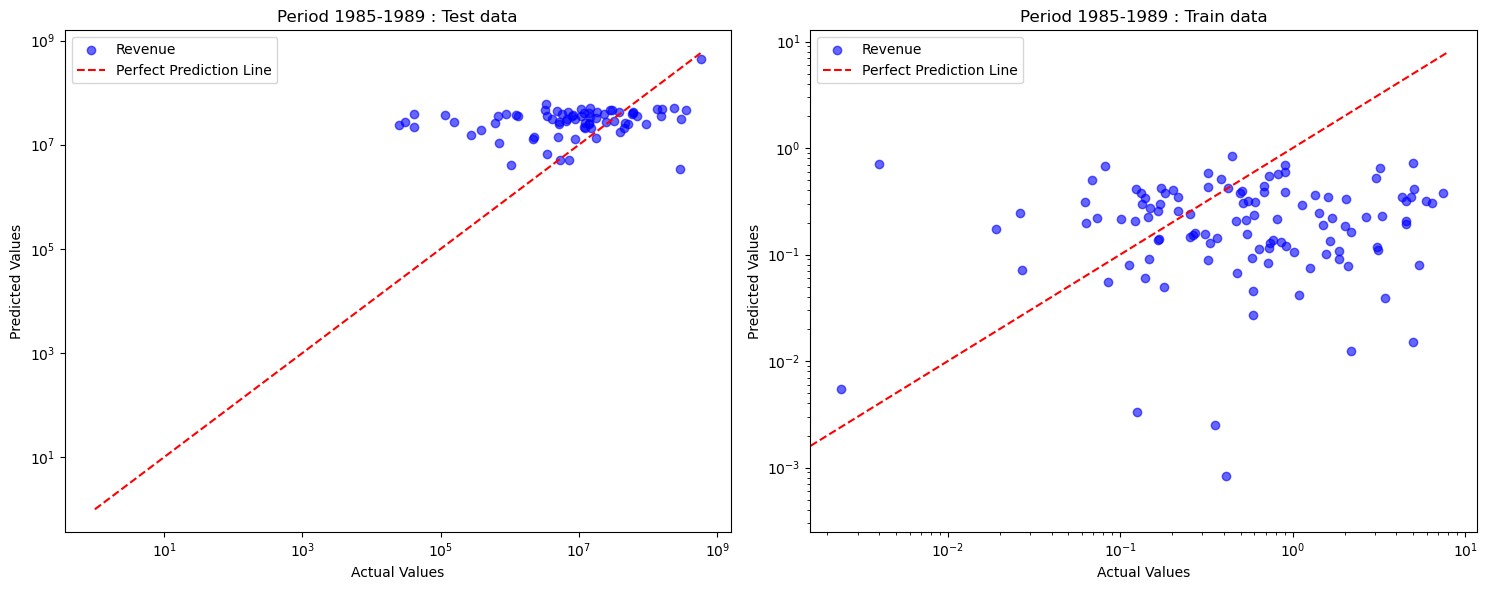

1990-1994

Model Statistics:
R-squared: 0.1810796442619993

Feature Coefficients and P-values:
                         Feature   Coefficient   P-value
9                      Adventure  7.056887e+07  0.000106
1                 actor_gender_F  6.521894e+07  0.003465
12   Fantasy and Science Fiction  6.216990e+07  0.002293
16             Crime and Mystery  6.153587e+07  0.002022
18             War and Political  6.025055e+07  0.002930
23        LGBT and Gender Issues  6.011878e+07  0.003009
20                     Animation  5.877701e+07  0.020740
22  Experimental and Independent  4.157570e+07  0.028149
4       actor_age_at_release_min  4.052944e+07  0.019056


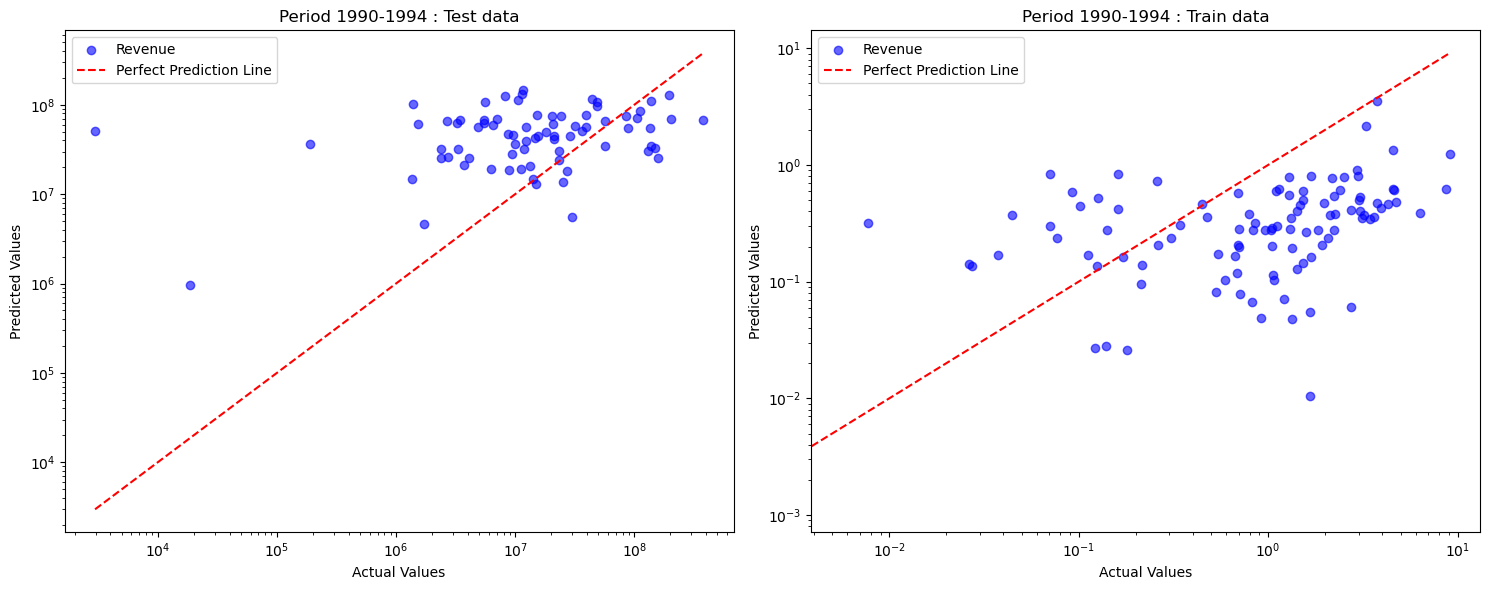

1995-1999

Model Statistics:
R-squared: 0.18421380798483988

Feature Coefficients and P-values:
                         Feature   Coefficient   P-value
25                  ethnic_score  7.823642e+07  0.047588
8                         Action  7.648458e+07  0.002619
12   Fantasy and Science Fiction  7.395408e+07  0.000577
14                       Romance  7.335134e+07  0.002686
20                     Animation  7.252474e+07  0.004064
5       actor_age_at_release_max  7.098815e+07  0.003269
15                   Documentary  6.859353e+07  0.020093
10                        Comedy  5.050865e+07  0.047631
3                        F ratio  5.019694e+07  0.042445
22  Experimental and Independent  4.847243e+07  0.006283
4       actor_age_at_release_min  4.842375e+07  0.006561
6        actor_height_meters_min  4.388805e+07  0.000132


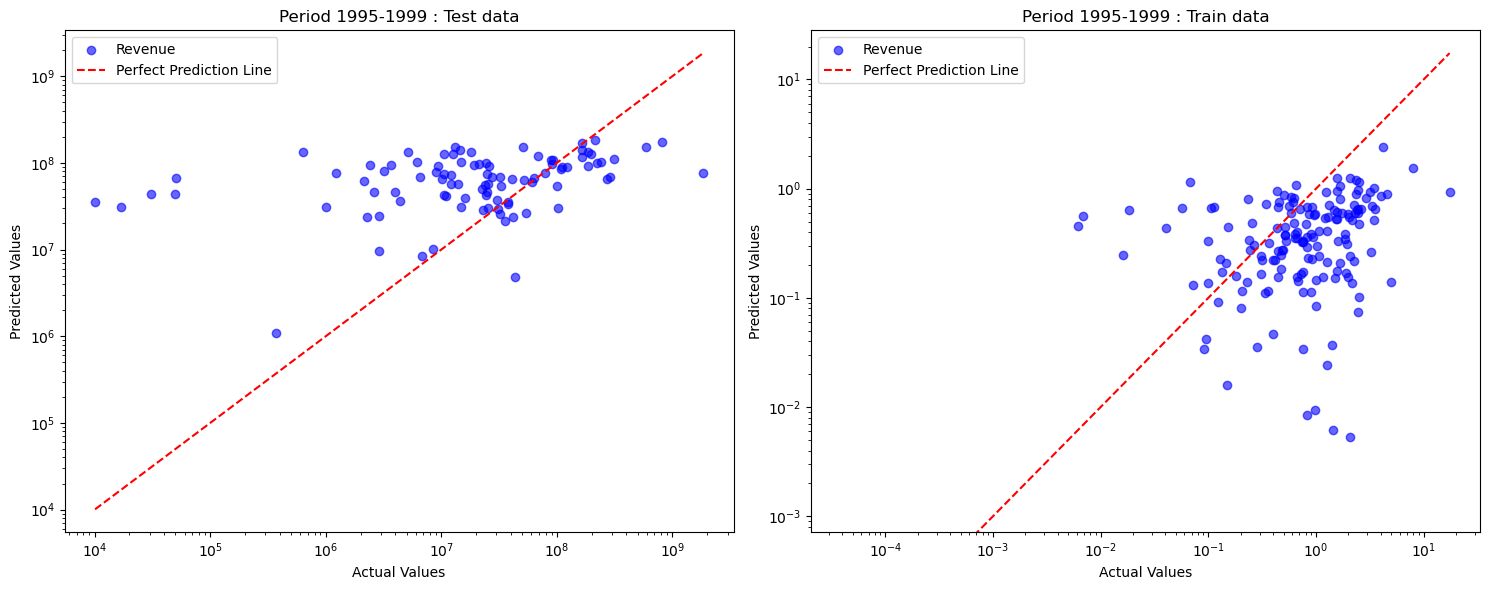

2000-2004

Model Statistics:
R-squared: 0.24528334760953008

Feature Coefficients and P-values:
                         Feature   Coefficient       P-value
12   Fantasy and Science Fiction  1.045489e+08  2.668752e-08
9                      Adventure  1.026151e+08  3.832285e-04
5       actor_age_at_release_max  1.004667e+08  2.316733e-07
10                        Comedy  6.836331e+07  2.414166e-02
22  Experimental and Independent  6.509774e+07  1.104315e-03
4       actor_age_at_release_min  6.188102e+07  6.158905e-05
6        actor_height_meters_min  5.929755e+07  6.011089e-06


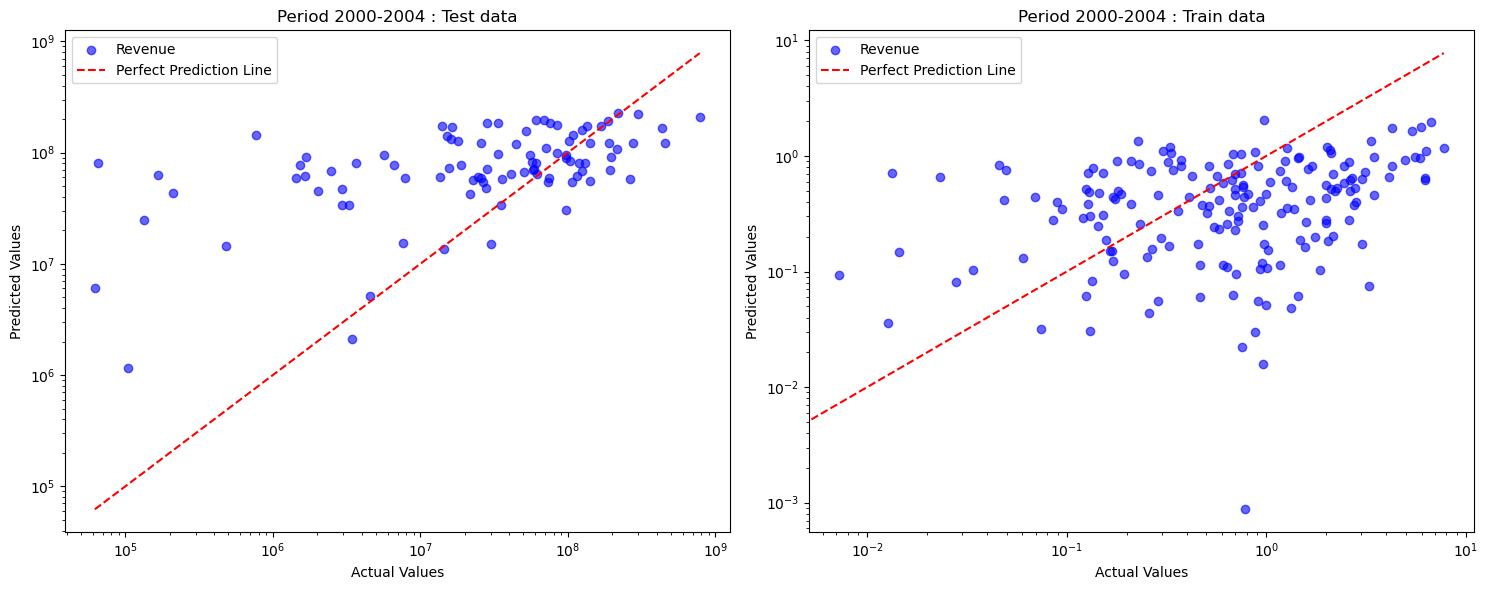

2005-2009

Model Statistics:
R-squared: 0.23063496978240738

Feature Coefficients and P-values:
                         Feature   Coefficient       P-value
12   Fantasy and Science Fiction  1.031156e+08  2.242079e-06
20                     Animation  9.861804e+07  2.063881e-04
9                      Adventure  9.772595e+07  3.180219e-03
14                       Romance  9.590801e+07  1.503312e-03
8                         Action  9.423157e+07  1.432178e-02
7        actor_height_meters_max  9.281176e+07  3.903942e-03
5       actor_age_at_release_max  8.972778e+07  2.313369e-02
22  Experimental and Independent  6.766919e+07  1.124613e-02
1                 actor_gender_F  6.194483e+07  2.487586e-02
6        actor_height_meters_min  5.099254e+07  3.834167e-09


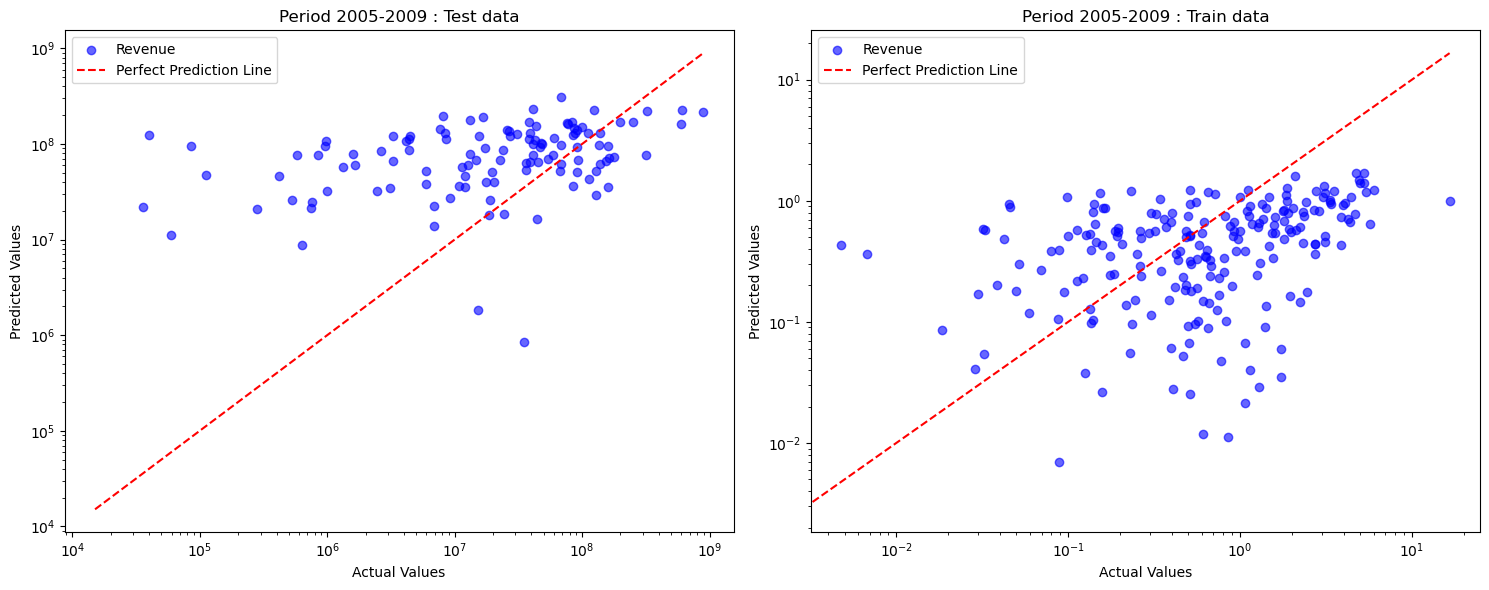

2010-2014

Model Statistics:
R-squared: 0.3337574210019294

Feature Coefficients and P-values:
                        Feature   Coefficient       P-value
25                 ethnic_score  1.747892e+08  2.063895e-04
9                     Adventure  1.541342e+08  5.424106e-06
12  Fantasy and Science Fiction  1.532138e+08  3.290025e-08
5      actor_age_at_release_max  1.285769e+08  7.069095e-03


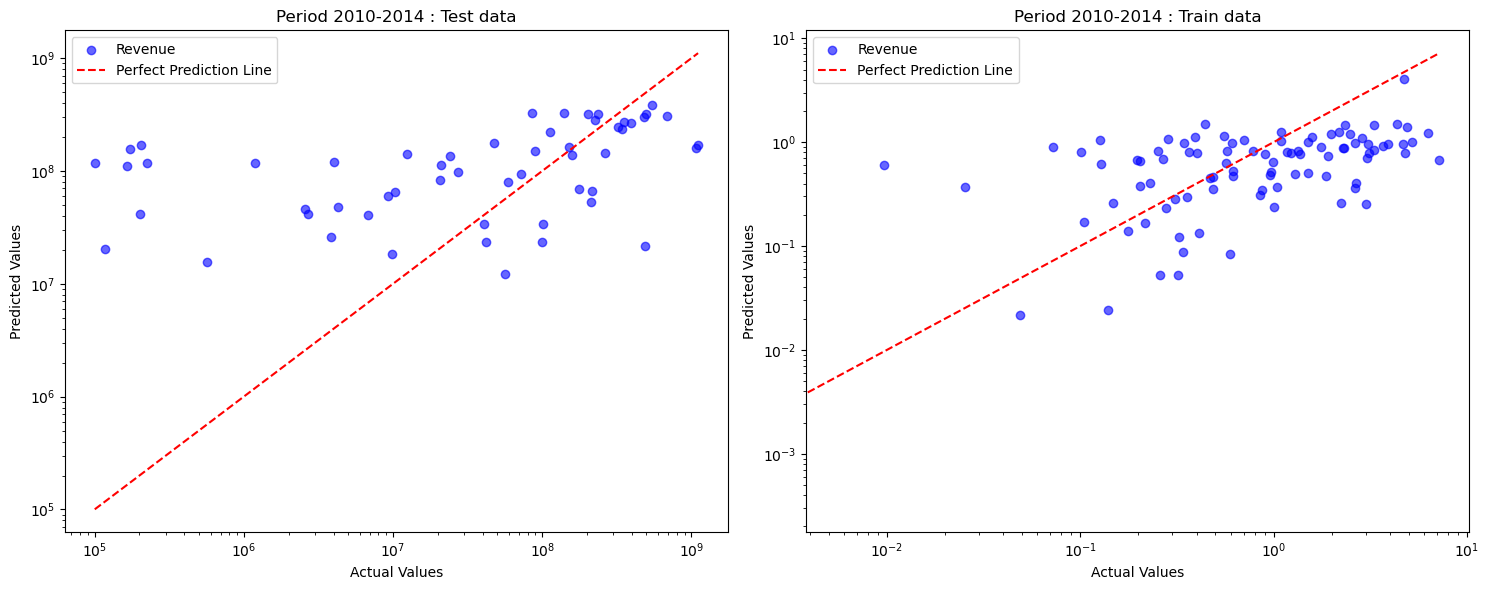


Number of movies in each period:
period
1985-1989     749
1990-1994     789
1995-1999     986
2000-2004    1005
2005-2009    1279
2010-2014     583
Name: count, dtype: int64


In [178]:
##Linear Regression model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from scipy import stats

df['Movie release date'] = df['Movie release date'].astype(int)

# First, let's create 5-year periods and count movies in each
df['period'] = df['Movie release date'].apply(lambda x: f"{x // 5 * 5}-{(x // 5 + 1) * 5 - 1}")
period_counts = df['period'].value_counts().sort_index()

# Print periods with more than 500 movies
valid_periods = period_counts[period_counts > 500].index

features_of_interest = {}  # Initialize as dictionary 


# For each valid period, run a separate regression
for period in valid_periods:
    # Filter data for this period
    period_data = df[df['period'] == period]
    
    # Split data
    X = period_data.drop(["Movie box office revenue", "period", "Movie release date", "African Ethnicities","Indigenous Peoples", "Western European Ethnicities", 
                          "Northern European Ethnicities", "Southern European Ethnicities", "Eastern European Ethnicities",
                           "Asian Ethnicities", "Middle Eastern and Arab Ethnicities","Latin American Ethnicities", "Jewish Communities", "American Ethnicities",
                            "Oceanian Ethnicities"], axis=1)
    y = period_data["Movie box office revenue"]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    
    # Scale features
    x_scaler = StandardScaler()
    xtrain = x_scaler.fit_transform(xtrain)
    xtest = x_scaler.transform(xtest)
    
    y_scaler = StandardScaler()
    ytrain = y_scaler.fit_transform(ytrain.values.reshape(-1, 1)).ravel()
    
    # Fit model
    model = Ridge(alpha=100.0)
    model.fit(xtrain, ytrain)
    
    # Predict and inverse transform
    ypred = model.predict(xtest)
    ypred = y_scaler.inverse_transform(ypred.reshape(-1, 1)).ravel()
    ypred_2 = model.predict(xtrain)
    #ypred_2 = y_scaler.inverse_transform(ypred_2.reshape(-1, 1)).ravel()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Create subplot
    ax1.scatter(ytest, ypred, alpha=0.6, label="Revenue", color="blue")
    ax1.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', label="Perfect Prediction Line")
    ax1.set_xscale('log')
    ax1.set_yscale("log")
    ax1.set_xlabel("Actual Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"Period {period} : Test data")
    ax1.legend()

    ax2.scatter(ytrain, ypred_2, alpha=0.6, label="Revenue", color="blue")
    ax2.plot([ytrain.min(), ytrain.max()], [ytrain.min(), ytrain.max()], 'r--', label="Perfect Prediction Line")
    ax2.set_xscale('log')
    ax2.set_yscale("log")
    ax2.set_xlabel("Actual Values")
    ax2.set_ylabel("Predicted Values")
    ax2.set_title(f"Period {period} : Train data")
    ax2.legend()

    # Statistical Summary
    X_with_const = sm.add_constant(xtrain)
    model_stats = sm.OLS(ytrain, X_with_const).fit()
    # Create a DataFrame with coefficients and p-values
    feature_names = ['const'] + list(X.columns)
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model_stats.params,
        'P-value': model_stats.pvalues
    })

    # Sort by absolute coefficient value
    coef_df['Abs_Coefficient'] = coef_df['Coefficient']
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    coef_df = coef_df.drop('Abs_Coefficient', axis=1)

    # Filter for p-value < 0.05 and display
    significant_features = coef_df[coef_df['P-value'] < 0.05]
    significant_features = significant_features[significant_features['Feature'] != 'const']
    # Inverse transform the coefficients to get them back to original scale
    # Corrected to use x_scaler for inverse transform
    significant_features['Coefficient'] = y_scaler.inverse_transform(significant_features['Coefficient'].values.reshape(-1, 1)).ravel()
    features_of_interest[period] = significant_features  # Store in dictionary


    # Display period information
    print(period)
    print("\nModel Statistics:")
    print("R-squared:", model_stats.rsquared)
    print("\nFeature Coefficients and P-values:")
    print(significant_features)

    plt.tight_layout()
    plt.show()

# Print the number of movies in each period
print("\nNumber of movies in each period:")
print(period_counts[valid_periods])




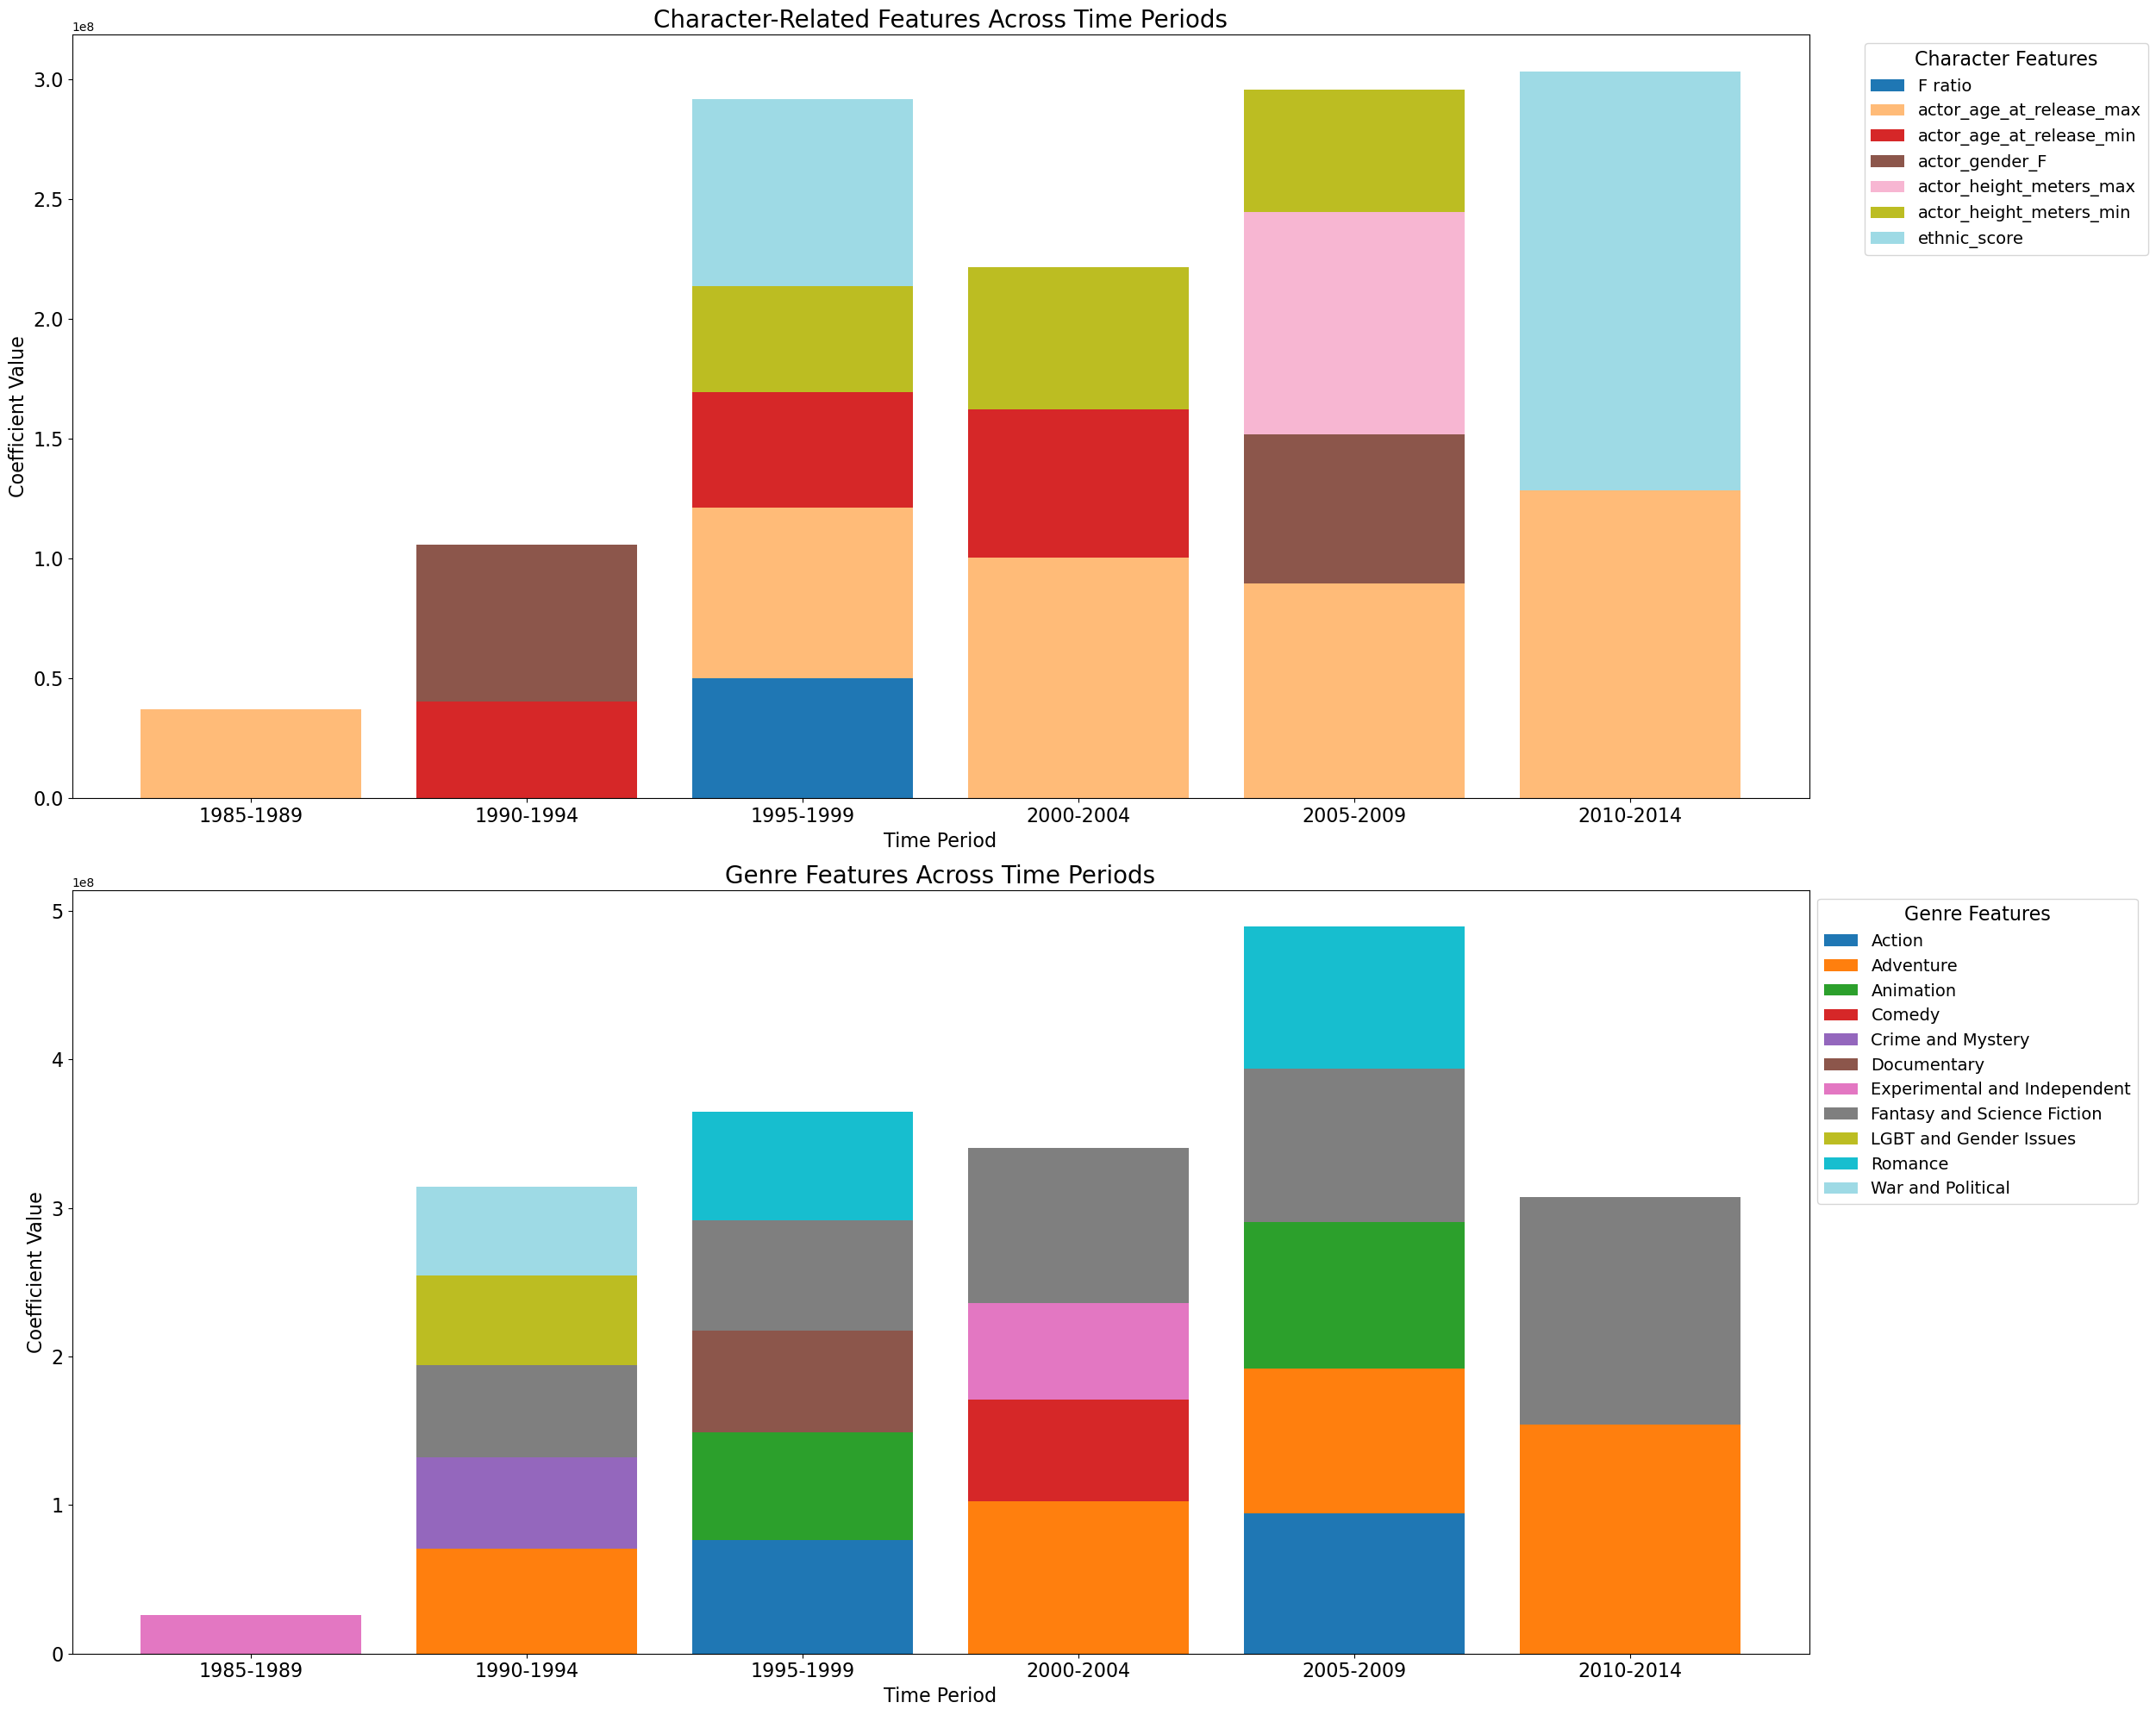

In [179]:
# Create DataFrames for character and genre features
character_df = pd.DataFrame()
genre_df = pd.DataFrame()

for period, features in features_of_interest.items():
    if len(features) == 0:  # Skip if no significant features for this period
        continue

    # Extract feature names and coefficients (retain original values)
    period_features = pd.DataFrame({
        'Feature': features['Feature'],
        'Coefficient': features['Coefficient']
    })
    
    # Split into character and genre features
    character_features = period_features[
        period_features['Feature'].str.contains('actor|ethnicities|F ratio|people|communities|score', case=False, regex=True)
    ].copy()
    
    genre_features = period_features[
        ~period_features['Feature'].str.contains('actor|ethnicities|F ratio|people|communities|score', case=False, regex=True)
    ].copy()

    # Keep only top 5 genre and character features based on absolute coefficient value
    genre_features = genre_features.nlargest(5, 'Coefficient')
    character_features = character_features.nlargest(5, "Coefficient")

    # Add period column
    character_features['Period'] = period
    genre_features['Period'] = period
    
    # Append to the respective DataFrames
    character_df = pd.concat([character_df, character_features])
    genre_df = pd.concat([genre_df, genre_features])

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20))

# Define distinct color palettes for each plot
char_colors = plt.cm.tab20(np.linspace(0, 1, len(character_df['Feature'].unique())))
genre_colors = plt.cm.tab20(np.linspace(0, 1, len(genre_df['Feature'].unique())))

# Plot character features (signed values)
char_plot_data = character_df.pivot_table(
    index='Period', 
    columns='Feature',
    values='Coefficient',
    fill_value=0
)
char_plot_data.plot(kind='bar', stacked=True, width=0.8, ax=ax1, color=char_colors)
ax1.set_title("Character-Related Features Across Time Periods", fontsize=20)
ax1.set_xlabel("Time Period", fontsize=16)
ax1.set_ylabel("Coefficient Value", fontsize=16)
ax1.tick_params(axis='x', rotation=0, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(title="Character Features", bbox_to_anchor=(1.2, 1), fontsize=14, title_fontsize=16)

# Plot genre features (signed values)
genre_plot_data = genre_df.pivot_table(
    index='Period',
    columns='Feature', 
    values='Coefficient',
    fill_value=0
)
genre_plot_data.plot(kind='bar', stacked=True, width=0.8, ax=ax2, color=genre_colors)
ax2.set_title("Genre Features Across Time Periods", fontsize=20)
ax2.set_xlabel("Time Period", fontsize=16)
ax2.set_ylabel("Coefficient Value", fontsize=16)
ax2.tick_params(axis='x', rotation=0, labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
legend = ax2.legend(title="Genre Features", bbox_to_anchor=(1.0, 1), fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()


1985-1989

Model Statistics:
R-squared: 0.1044707166782346

Feature Coefficients and P-values:
                     Feature   Coefficient   P-value
19      Oceanian Ethnicities  3.825314e+07  0.000868
5   actor_age_at_release_max  3.770689e+07  0.003372


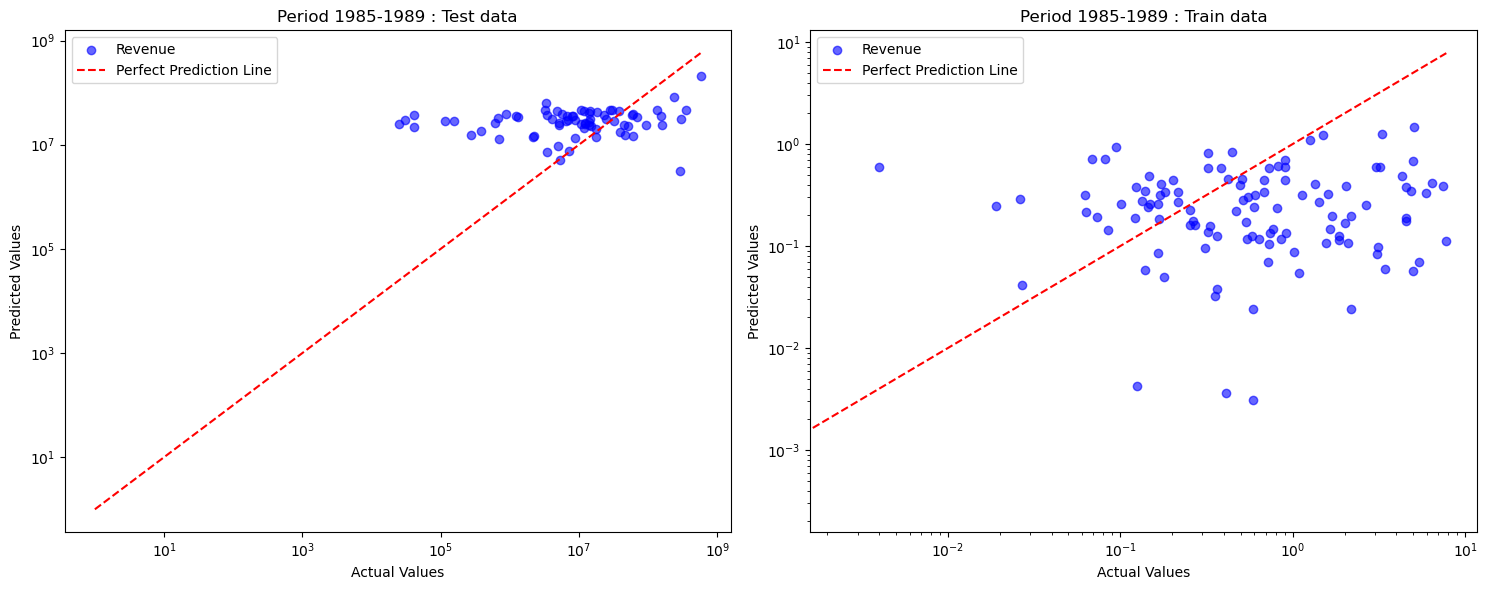

1990-1994

Model Statistics:
R-squared: 0.20588367541572716

Feature Coefficients and P-values:
                         Feature   Coefficient   P-value
2                 actor_gender_M  1.512219e+08  0.000071
21                     Adventure  7.077331e+07  0.000091
24   Fantasy and Science Fiction  6.091163e+07  0.006036
28             Crime and Mystery  6.006556e+07  0.007115
35        LGBT and Gender Issues  5.997653e+07  0.003272
30             War and Political  5.908432e+07  0.008242
32                     Animation  5.799675e+07  0.033898
34  Experimental and Independent  4.194251e+07  0.035515
13  Eastern European Ethnicities  4.120218e+07  0.028668
4       actor_age_at_release_min  4.078453e+07  0.023120
17            Jewish Communities  2.903985e+07  0.047942
10  Western European Ethnicities  2.505762e+07  0.011069
37                  ethnic_score  2.437609e+07  0.000196
19          Oceanian Ethnicities  4.759156e+06  0.001192


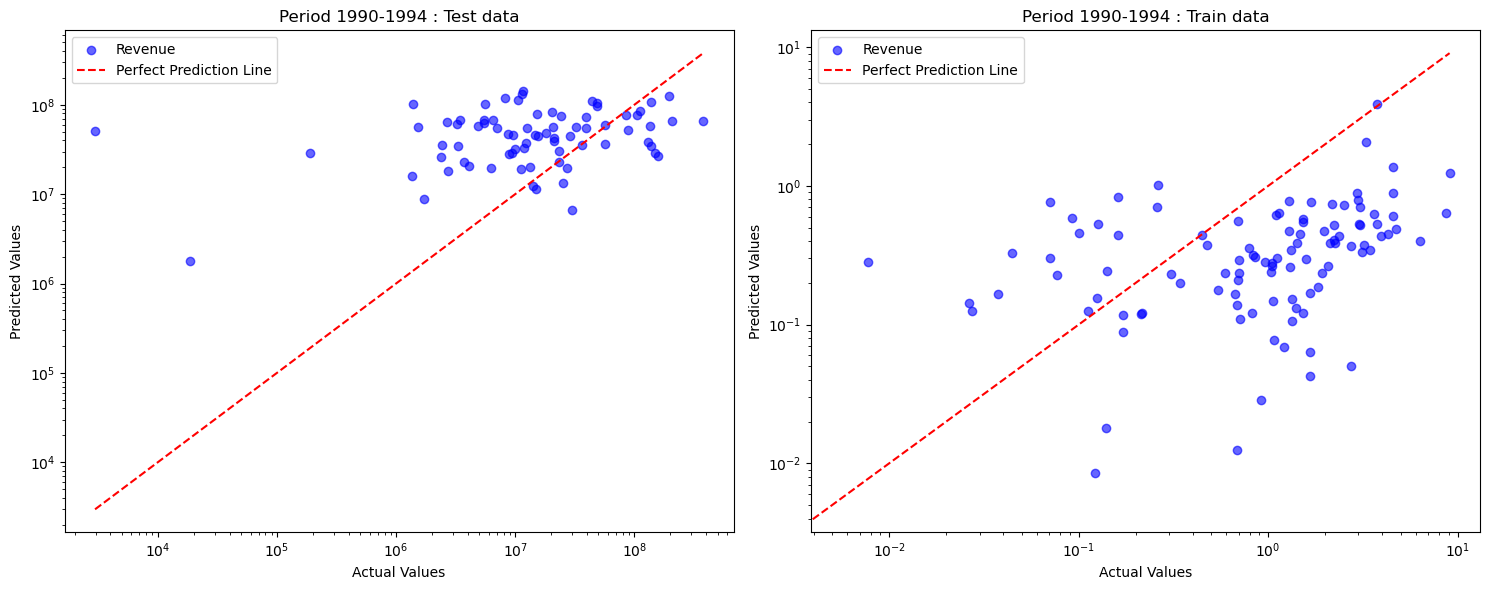

1995-1999

Model Statistics:
R-squared: 0.2711227091095306

Feature Coefficients and P-values:
                         Feature   Coefficient       P-value
13  Eastern European Ethnicities  9.210708e+07  2.778874e-17
18          American Ethnicities  8.819146e+07  4.696085e-02
24   Fantasy and Science Fiction  7.426754e+07  2.658597e-04
20                        Action  7.413270e+07  6.672089e-03
32                     Animation  7.223896e+07  3.435133e-03
26                       Romance  7.203708e+07  4.509649e-03
27                   Documentary  7.064824e+07  3.176576e-03
5       actor_age_at_release_max  7.027618e+07  3.926745e-03
34  Experimental and Independent  4.841341e+07  3.952630e-03
4       actor_age_at_release_min  4.807453e+07  3.337484e-03
6        actor_height_meters_min  4.395779e+07  6.873606e-05
8            African Ethnicities  3.860114e+07  3.968822e-02


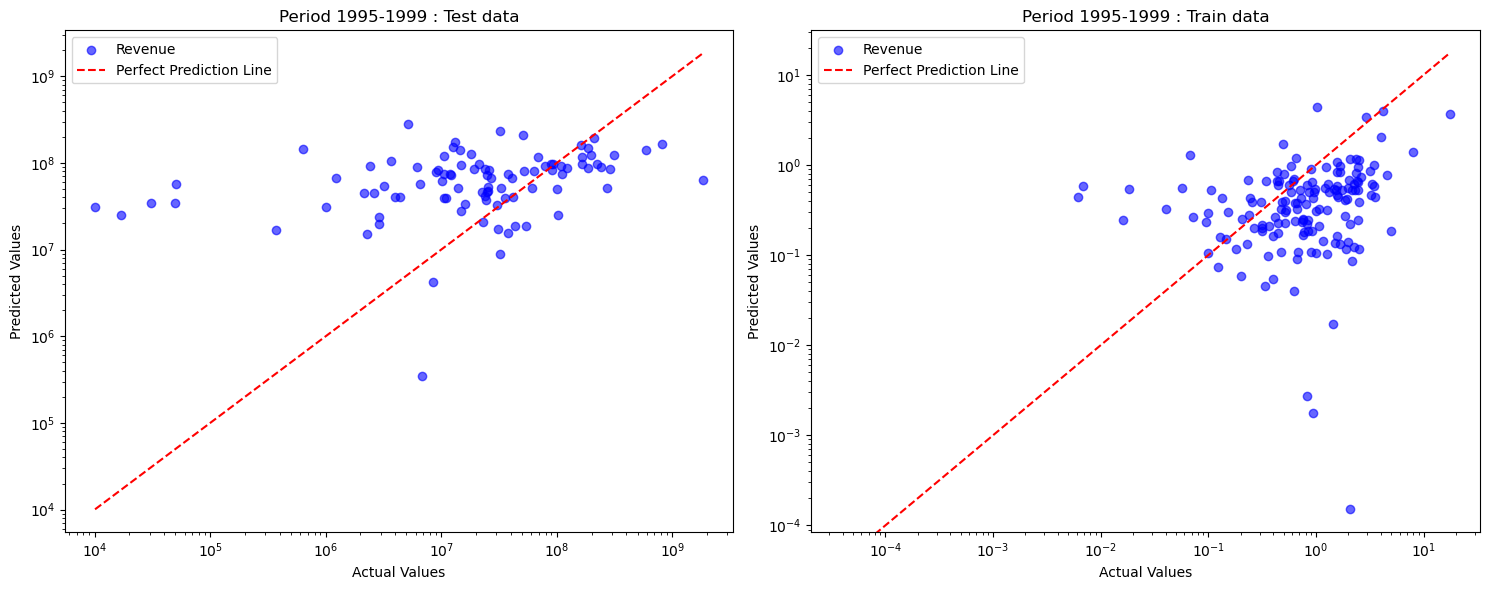

2000-2004

Model Statistics:
R-squared: 0.25754531853151563

Feature Coefficients and P-values:
                         Feature   Coefficient       P-value
24   Fantasy and Science Fiction  1.051845e+08  1.559203e-08
21                     Adventure  1.015854e+08  7.019008e-04
5       actor_age_at_release_max  9.951919e+07  1.057012e-06
9             Indigenous Peoples  8.877493e+07  1.619595e-02
19          Oceanian Ethnicities  8.855997e+07  3.700612e-02
34  Experimental and Independent  6.503488e+07  1.072824e-03
4       actor_age_at_release_min  6.272862e+07  1.532324e-04
6        actor_height_meters_min  5.969783e+07  9.777359e-06


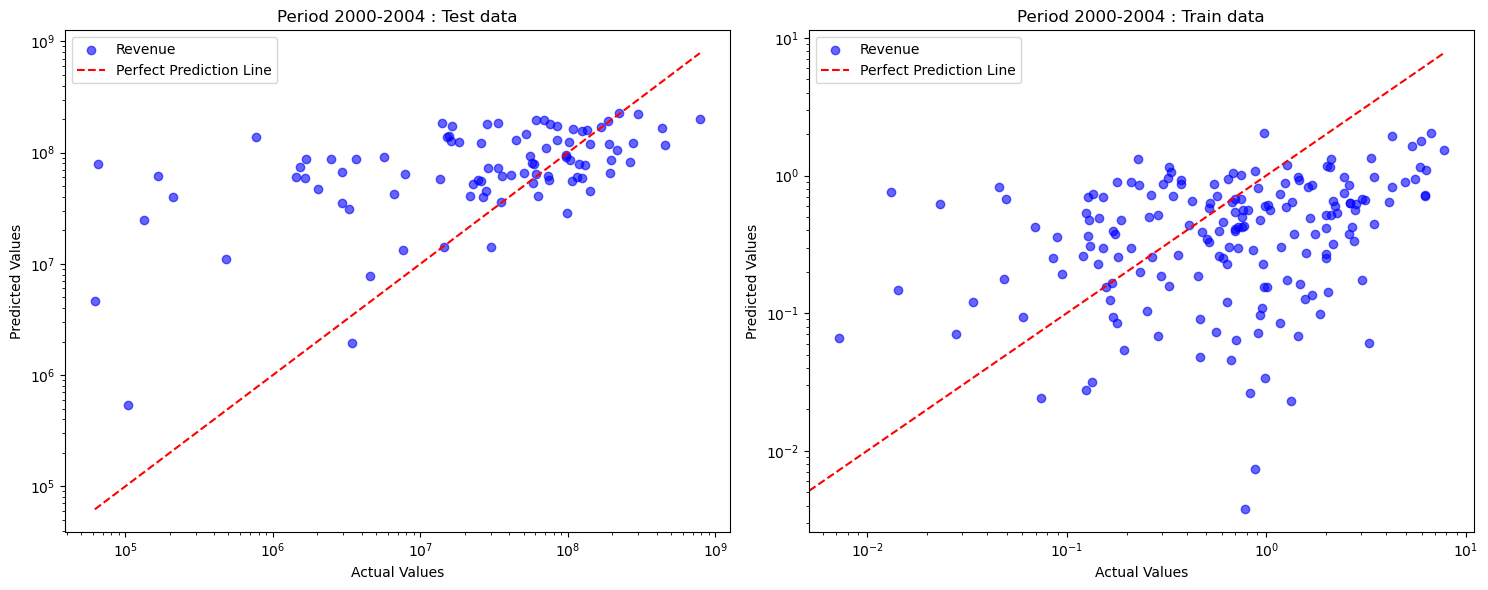

2005-2009

Model Statistics:
R-squared: 0.25049865297915597

Feature Coefficients and P-values:
                         Feature   Coefficient       P-value
10  Western European Ethnicities  1.040032e+08  1.083634e-05
24   Fantasy and Science Fiction  1.009770e+08  1.662539e-05
32                     Animation  9.885892e+07  1.588566e-04
20                        Action  9.624172e+07  5.289688e-03
17            Jewish Communities  9.522850e+07  2.415522e-03
21                     Adventure  9.512177e+07  1.153889e-02
26                       Romance  9.485779e+07  2.867544e-03
7        actor_height_meters_max  9.293823e+07  3.561486e-03
5       actor_age_at_release_max  8.832401e+07  4.990830e-02
37                  ethnic_score  8.393674e+07  4.056643e-02
34  Experimental and Independent  6.763400e+07  1.065495e-02
1                 actor_gender_F  6.195345e+07  4.386545e-02
18          American Ethnicities  5.491603e+07  4.222479e-02
6        actor_height_meters_min  5.227120e+07  1.

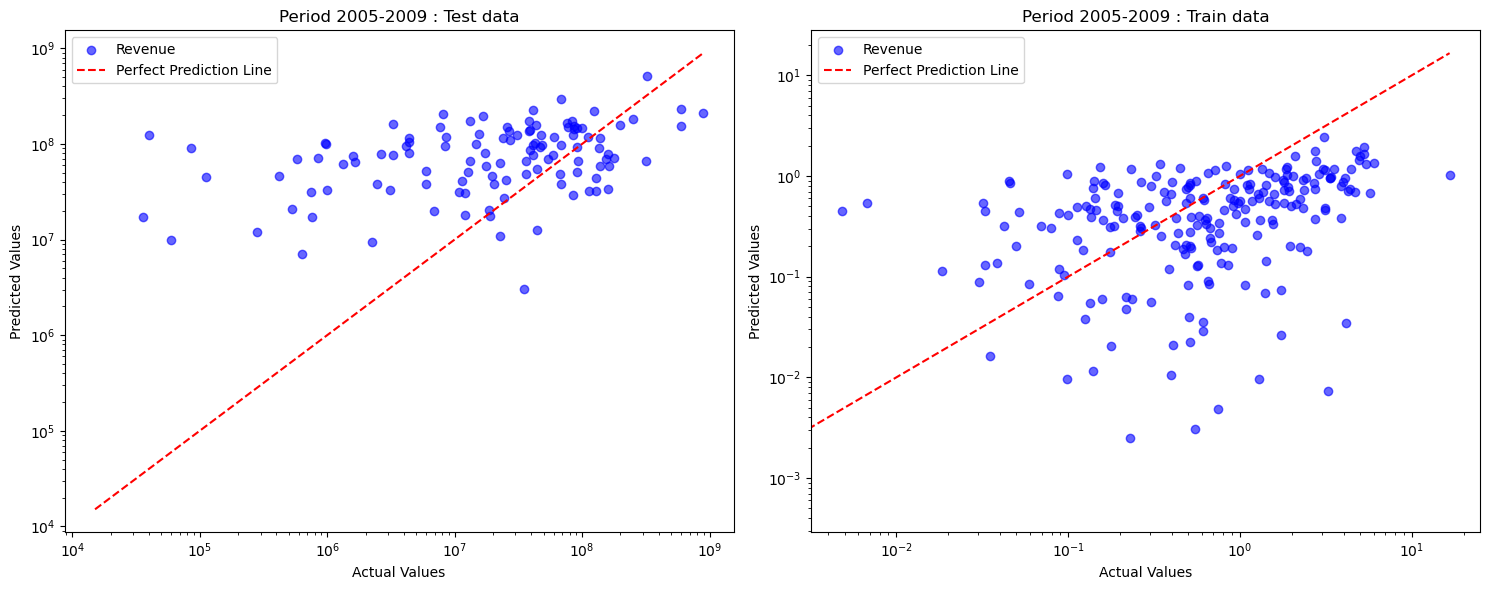

2010-2014

Model Statistics:
R-squared: 0.3621309681857702

Feature Coefficients and P-values:
                          Feature   Coefficient       P-value
21                      Adventure  1.590509e+08  6.390028e-07
24    Fantasy and Science Fiction  1.520531e+08  1.091854e-07
12  Southern European Ethnicities  1.467521e+08  4.404142e-04
5        actor_age_at_release_max  1.246345e+08  2.853003e-02
6         actor_height_meters_min  9.163592e+07  4.936236e-02
16     Latin American Ethnicities  9.054651e+07  3.878552e-02


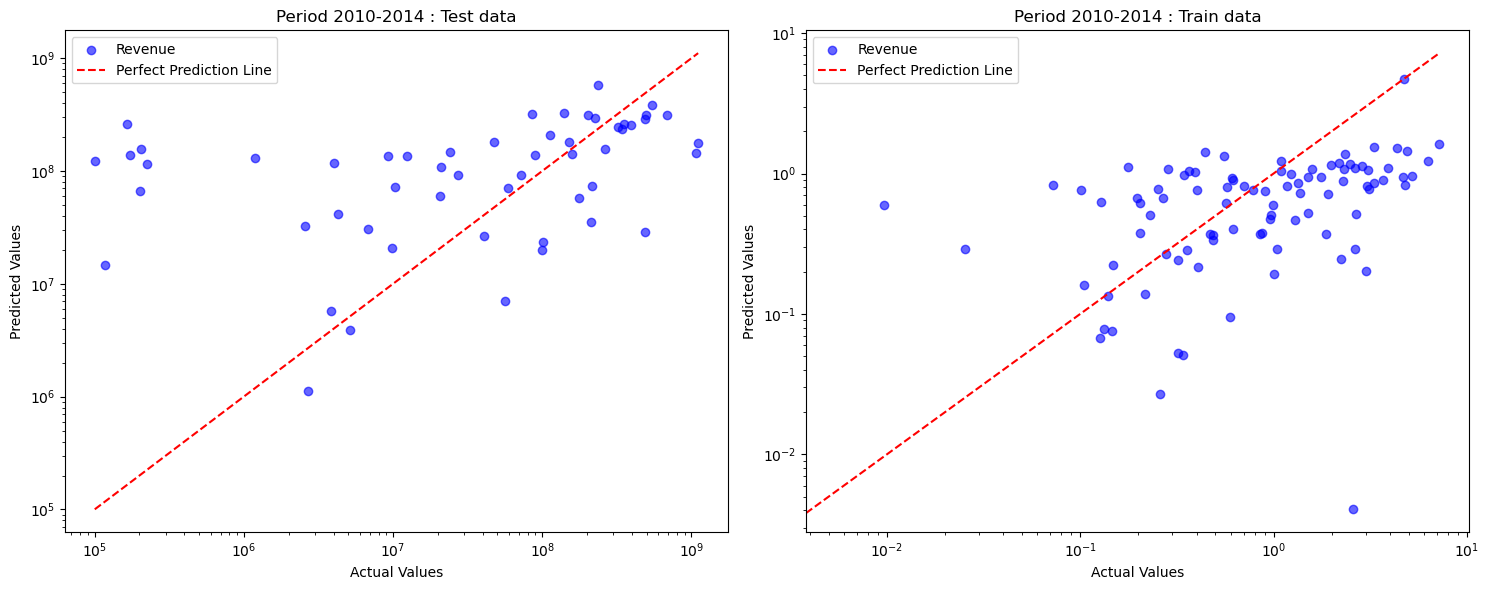


Number of movies in each period:
period
1985-1989     749
1990-1994     789
1995-1999     986
2000-2004    1005
2005-2009    1279
2010-2014     583
Name: count, dtype: int64


In [181]:
##Linear Regression model 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from scipy import stats

features_of_interest = {}  # Initialize as dictionary 


# For each valid period, run a separate regression
for period in valid_periods:
    # Filter data for this period
    period_data = df[df['period'] == period]
    
    # Split data
    X = period_data.drop(["Movie box office revenue", "period", "Movie release date"], axis=1)
    y = period_data["Movie box office revenue"]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    
    # Scale features
    x_scaler = StandardScaler()
    xtrain = x_scaler.fit_transform(xtrain)
    xtest = x_scaler.transform(xtest)
    
    y_scaler = StandardScaler()
    ytrain = y_scaler.fit_transform(ytrain.values.reshape(-1, 1)).ravel()
    
    # Fit model
    model = Ridge(alpha=100.0)
    model.fit(xtrain, ytrain)
    
    # Predict and inverse transform
    ypred = model.predict(xtest)
    ypred = y_scaler.inverse_transform(ypred.reshape(-1, 1)).ravel()
    ypred_2 = model.predict(xtrain)
    #ypred_2 = y_scaler.inverse_transform(ypred_2.reshape(-1, 1)).ravel()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Create subplot
    ax1.scatter(ytest, ypred, alpha=0.6, label="Revenue", color="blue")
    ax1.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', label="Perfect Prediction Line")
    ax1.set_xscale('log')
    ax1.set_yscale("log")
    ax1.set_xlabel("Actual Values")
    ax1.set_ylabel("Predicted Values")
    ax1.set_title(f"Period {period} : Test data")
    ax1.legend()

    ax2.scatter(ytrain, ypred_2, alpha=0.6, label="Revenue", color="blue")
    ax2.plot([ytrain.min(), ytrain.max()], [ytrain.min(), ytrain.max()], 'r--', label="Perfect Prediction Line")
    ax2.set_xscale('log')
    ax2.set_yscale("log")
    ax2.set_xlabel("Actual Values")
    ax2.set_ylabel("Predicted Values")
    ax2.set_title(f"Period {period} : Train data")
    ax2.legend()

    # Statistical Summary
    X_with_const = sm.add_constant(xtrain)
    model_stats = sm.OLS(ytrain, X_with_const).fit()
    # Create a DataFrame with coefficients and p-values
    feature_names = ['const'] + list(X.columns)
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model_stats.params,
        'P-value': model_stats.pvalues
    })

    ###Change code snippet because we dont sort by absolute value anymore
    coef_df['Abs_Coefficient'] = coef_df['Coefficient']
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    coef_df = coef_df.drop('Abs_Coefficient', axis=1)

    # Filter for p-value < 0.05 and display
    significant_features = coef_df[coef_df['P-value'] < 0.05]
    significant_features = significant_features[significant_features['Feature'] != 'const']
    # Inverse transform the coefficients to get them back to original scale
    # Corrected to use x_scaler for inverse transform
    significant_features['Coefficient'] = y_scaler.inverse_transform(significant_features['Coefficient'].values.reshape(-1, 1)).ravel()
    features_of_interest[period] = significant_features  # Store in dictionary


    # Display period information
    print(period)
    print("\nModel Statistics:")
    print("R-squared:", model_stats.rsquared)
    print("\nFeature Coefficients and P-values:")
    print(significant_features)

    plt.tight_layout()
    plt.show()

# Print the number of movies in each period
print("\nNumber of movies in each period:")
print(period_counts[valid_periods])


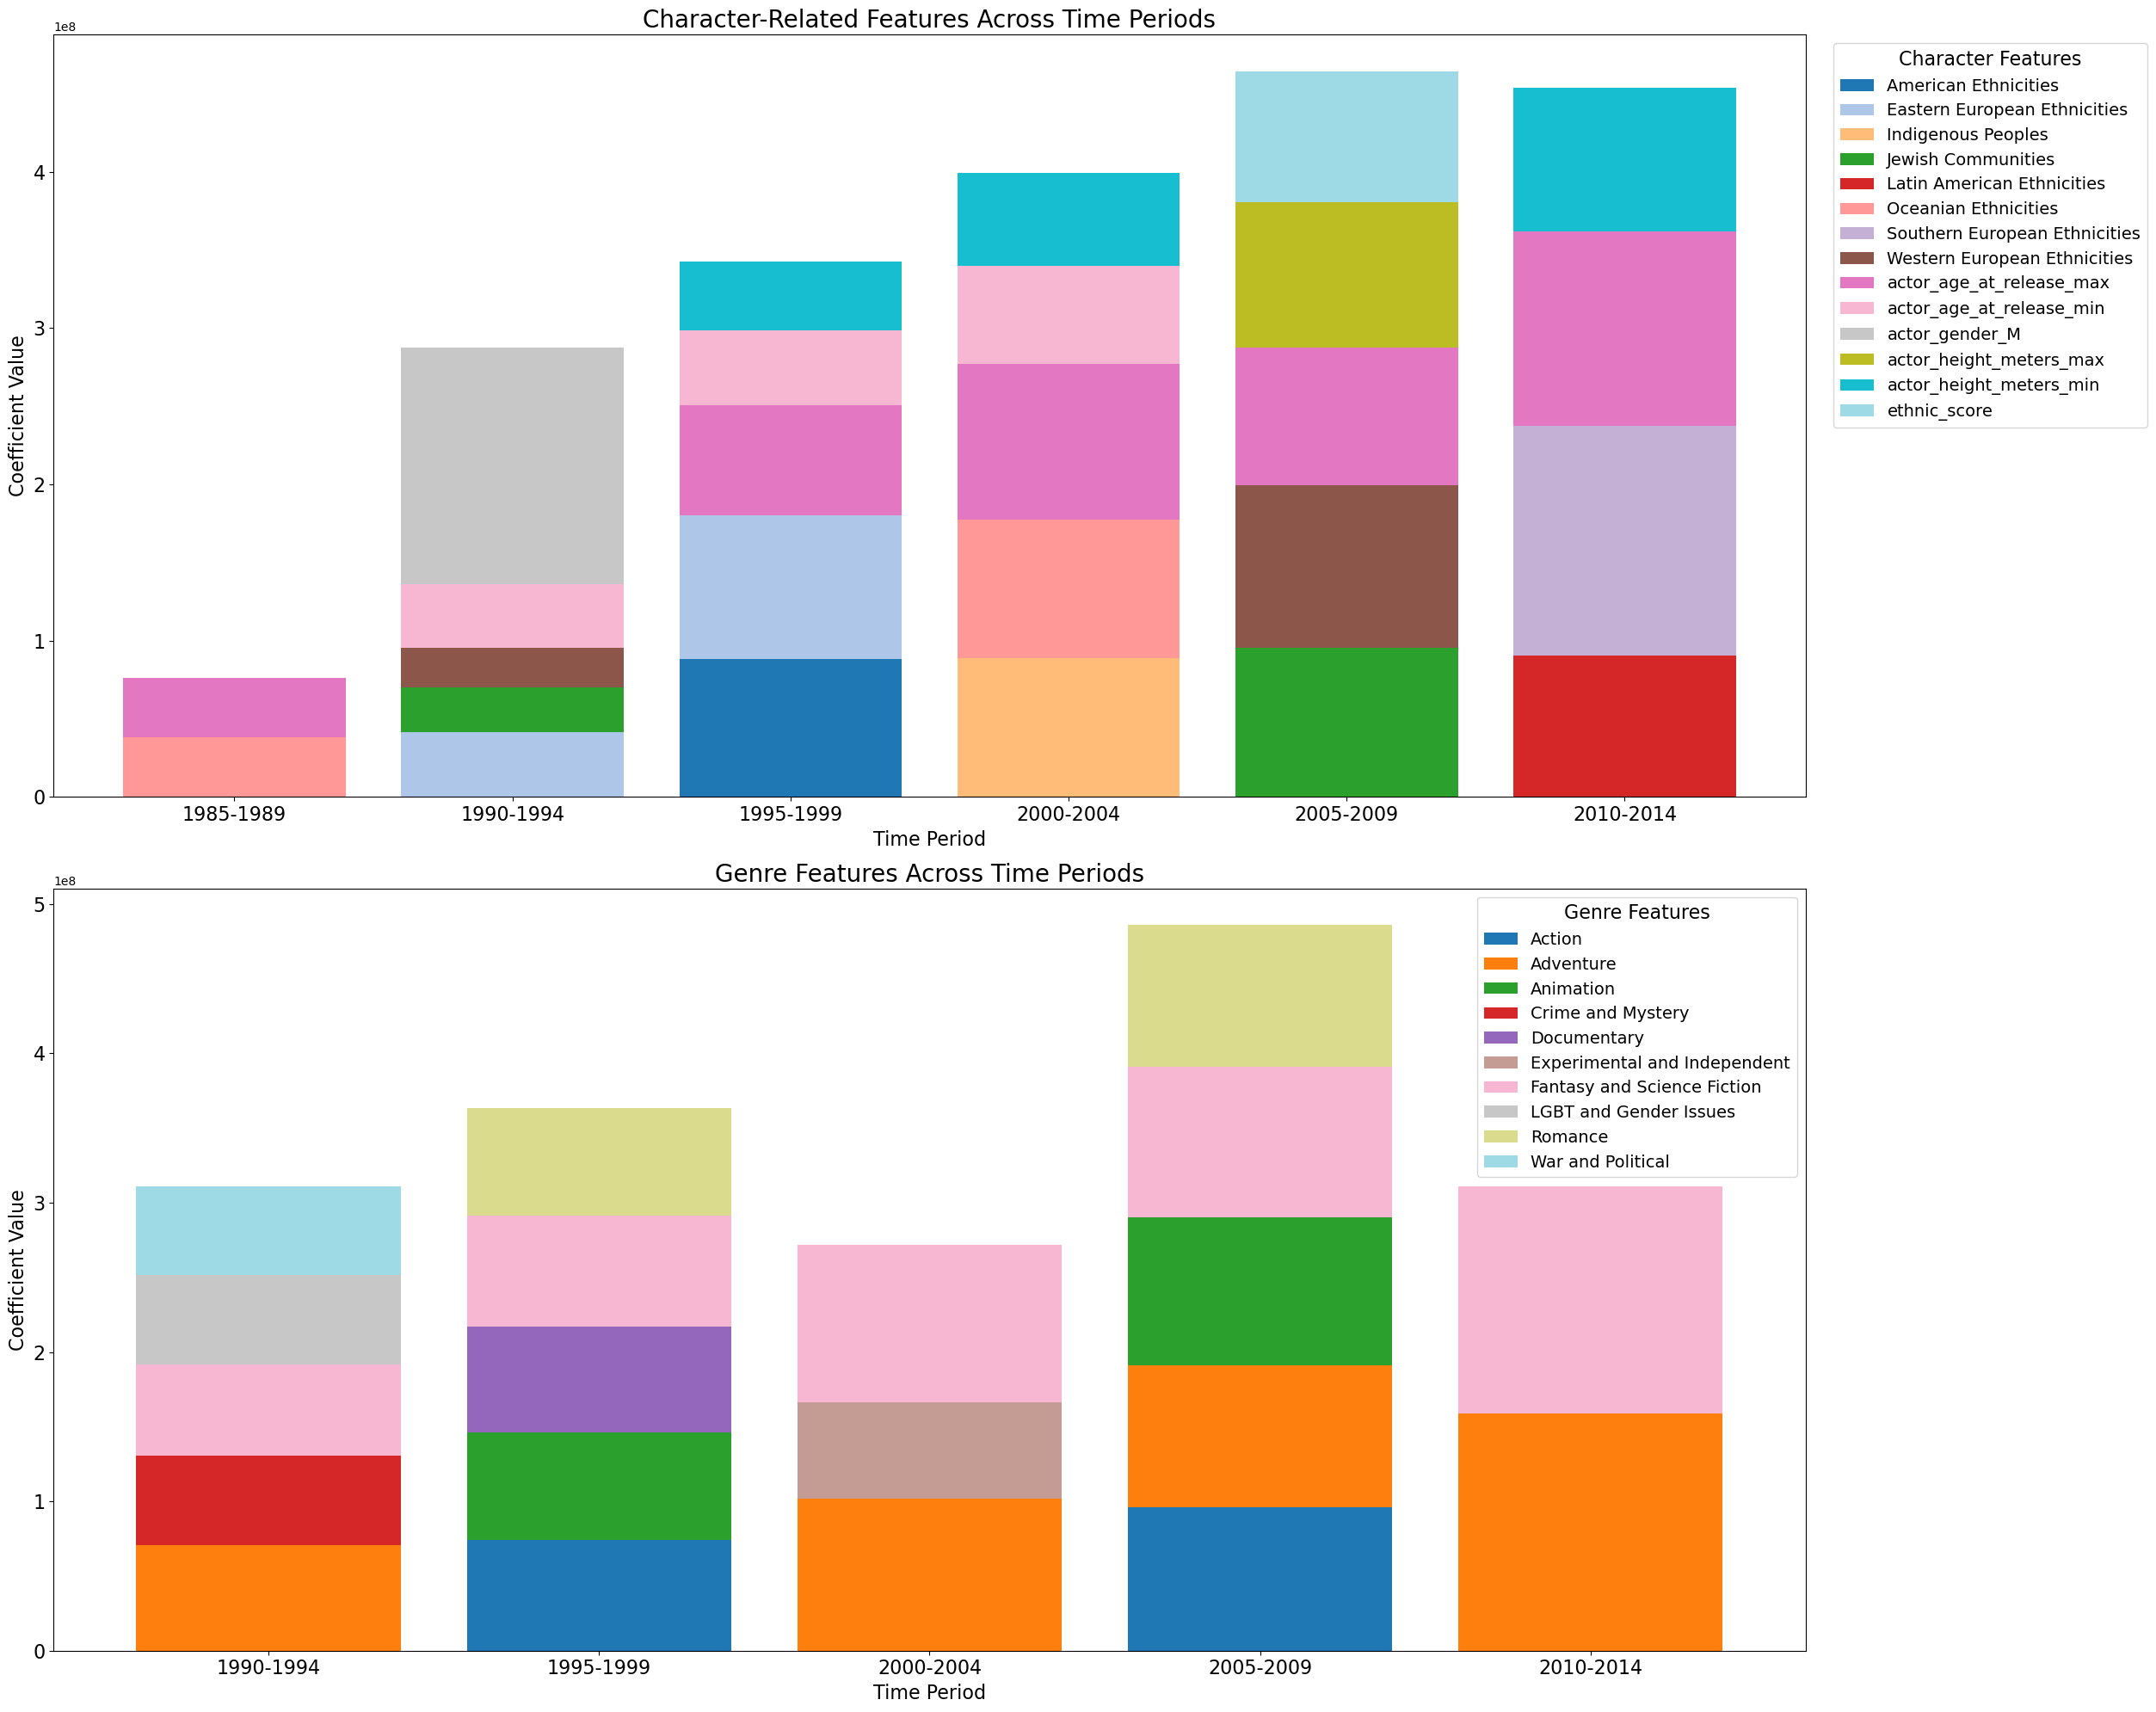

In [182]:
# Create DataFrames for character and genre features
character_df = pd.DataFrame()
genre_df = pd.DataFrame()

for period, features in features_of_interest.items():
    if len(features) == 0:  # Skip if no significant features for this period
        continue

    # Extract feature names and coefficients (retain original values)
    period_features = pd.DataFrame({
        'Feature': features['Feature'],
        'Coefficient': features['Coefficient']
    })
    
    # Split into character and genre features
    character_features = period_features[
        period_features['Feature'].str.contains('actor|ethnicities|F ratio|people|communities|score', case=False, regex=True)
    ].copy()
    
    genre_features = period_features[
        ~period_features['Feature'].str.contains('actor|ethnicities|F ratio|people|communities|score', case=False, regex=True)
    ].copy()

    # Keep only top 5 genre and character features based on absolute coefficient value
    genre_features = genre_features.nlargest(5, 'Coefficient')
    character_features = character_features.nlargest(5, "Coefficient")

    # Add period column
    character_features['Period'] = period
    genre_features['Period'] = period
    
    # Append to the respective DataFrames
    character_df = pd.concat([character_df, character_features])
    genre_df = pd.concat([genre_df, genre_features])

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20))

# Define distinct color palettes for each plot
char_colors = plt.cm.tab20(np.linspace(0, 1, len(character_df['Feature'].unique())))
genre_colors = plt.cm.tab20(np.linspace(0, 1, len(genre_df['Feature'].unique())))

# Plot character features (signed values)
char_plot_data = character_df.pivot_table(
    index='Period', 
    columns='Feature',
    values='Coefficient',
    fill_value=0
)
char_plot_data.plot(kind='bar', stacked=True, width=0.8, ax=ax1, color=char_colors)
ax1.set_title("Character-Related Features Across Time Periods", fontsize=20)
ax1.set_xlabel("Time Period", fontsize=16)
ax1.set_ylabel("Coefficient Value", fontsize=16)
ax1.tick_params(axis='x', rotation=0, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(title="Character Features", bbox_to_anchor=(1.2, 1), fontsize=14, title_fontsize=16)

# Plot genre features (signed values)
genre_plot_data = genre_df.pivot_table(
    index='Period',
    columns='Feature', 
    values='Coefficient',
    fill_value=0
)
genre_plot_data.plot(kind='bar', stacked=True, width=0.8, ax=ax2, color=genre_colors)
ax2.set_title("Genre Features Across Time Periods", fontsize=20)
ax2.set_xlabel("Time Period", fontsize=16)
ax2.set_ylabel("Coefficient Value", fontsize=16)
ax2.tick_params(axis='x', rotation=0, labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
legend = ax2.legend(title="Genre Features", bbox_to_anchor=(1.0, 1), fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()


In [183]:
##Logistic Regression model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import statsmodels.api as sm
from scipy import stats

df['Movie release date'] = df['Movie release date'].astype(int)

# First, let's create 5-year periods and count movies in each
#df['period'] = df['Movie release date'].apply(lambda x: f"{x // 5 * 5}-{(x // 5 + 1) * 5 - 1}")
#period_counts = df['period'].value_counts().sort_index()

# Print periods with more than 500 movies
#valid_periods = period_counts[period_counts > 500].index

features_of_interest = {}  

# For each valid period, run a separate regression
for period in valid_periods:
    # Filter data for this period
    period_data = df[df['period'] == period]
    
    # Split data
    X = period_data.drop(["Movie box office revenue", "period", "Movie release date"], axis=1)
    y = period_data["Movie box office revenue"]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    
    # Scale features
    x_scaler = StandardScaler()
    xtrain = x_scaler.fit_transform(xtrain)
    xtest = x_scaler.transform(xtest)
    
    # Convert to binary for logistic regression
    ytrain = ytrain > 300000000
    ytest = ytest > 300000000
    
    # Fit model
    model = LogisticRegression()
    model.fit(xtrain, ytrain)
    
    # Predict
    ypred = model.predict(xtest)
    ypred_2 = model.predict(xtrain)

    # Calculate F-1 score
    f1 = f1_score(ytest, ypred)
    
    # Statistical Summary
    model_stats = sm.Logit(ytrain, xtrain).fit()
    # Create a DataFrame with coefficients and p-values
    feature_names = list(X.columns)
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model_stats.params,
        'P-value': model_stats.pvalues
    })

    # Print period information
    print(period)
    print("\nModel Statistics:")
    print("F-1 Score:", f1)
    print("\nFeature Coefficients and P-values:")
    print(coef_df)

    # Store in dictionary
    features_of_interest[period] = coef_df  # Store in dictionary

# Print the number of movies in each period
print("\nNumber of movies in each period:")
print(period_counts[valid_periods])


         Current function value: 0.691306
         Iterations: 35
1985-1989

Model Statistics:
F-1 Score: 0.0

Feature Coefficients and P-values:
                                 Feature  Coefficient   P-value
x1                        actor_gender_F    -0.034832  0.836043
x2                        actor_gender_M     0.020715  0.900811
x3                               F ratio    -0.005290  0.959678
x4              actor_age_at_release_min    -0.016444  0.845780
x5              actor_age_at_release_max     0.035024  0.673557
x6               actor_height_meters_min     0.020938  0.806788
x7               actor_height_meters_max     0.000215  0.997958
x8                   African Ethnicities    -0.080757  1.000000
x9                    Indigenous Peoples    -0.018064  1.000000
x10         Western European Ethnicities    -0.035631  1.000000
x11        Northern European Ethnicities     0.017456  1.000000
x12        Southern European Ethnicities    -0.014524  1.000000
x13         Eastern Eu

c:\Users\eddli\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.642484
         Iterations 31
1995-1999

Model Statistics:
F-1 Score: 0.0

Feature Coefficients and P-values:
                                 Feature  Coefficient   P-value
x1                        actor_gender_F     0.043984  0.824822
x2                        actor_gender_M     0.144674  0.728949
x3                               F ratio    -0.091076  0.303520
x4              actor_age_at_release_min    -0.057571  0.449365
x5              actor_age_at_release_max     0.012853  0.861533
x6               actor_height_meters_min    -0.118171  0.121557
x7               actor_height_meters_max     0.041512  0.570797
x8                   African Ethnicities    -0.058737  1.000000
x9                    Indigenous Peoples    -0.122308  0.999999
x10         Western European Ethnicities    -0.288868  1.000000
x11        Northern European Ethnicities    -0.094186  1.000000
x12        Southern European Ethnicities    -0.00

c:\Users\eddli\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\eddli\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


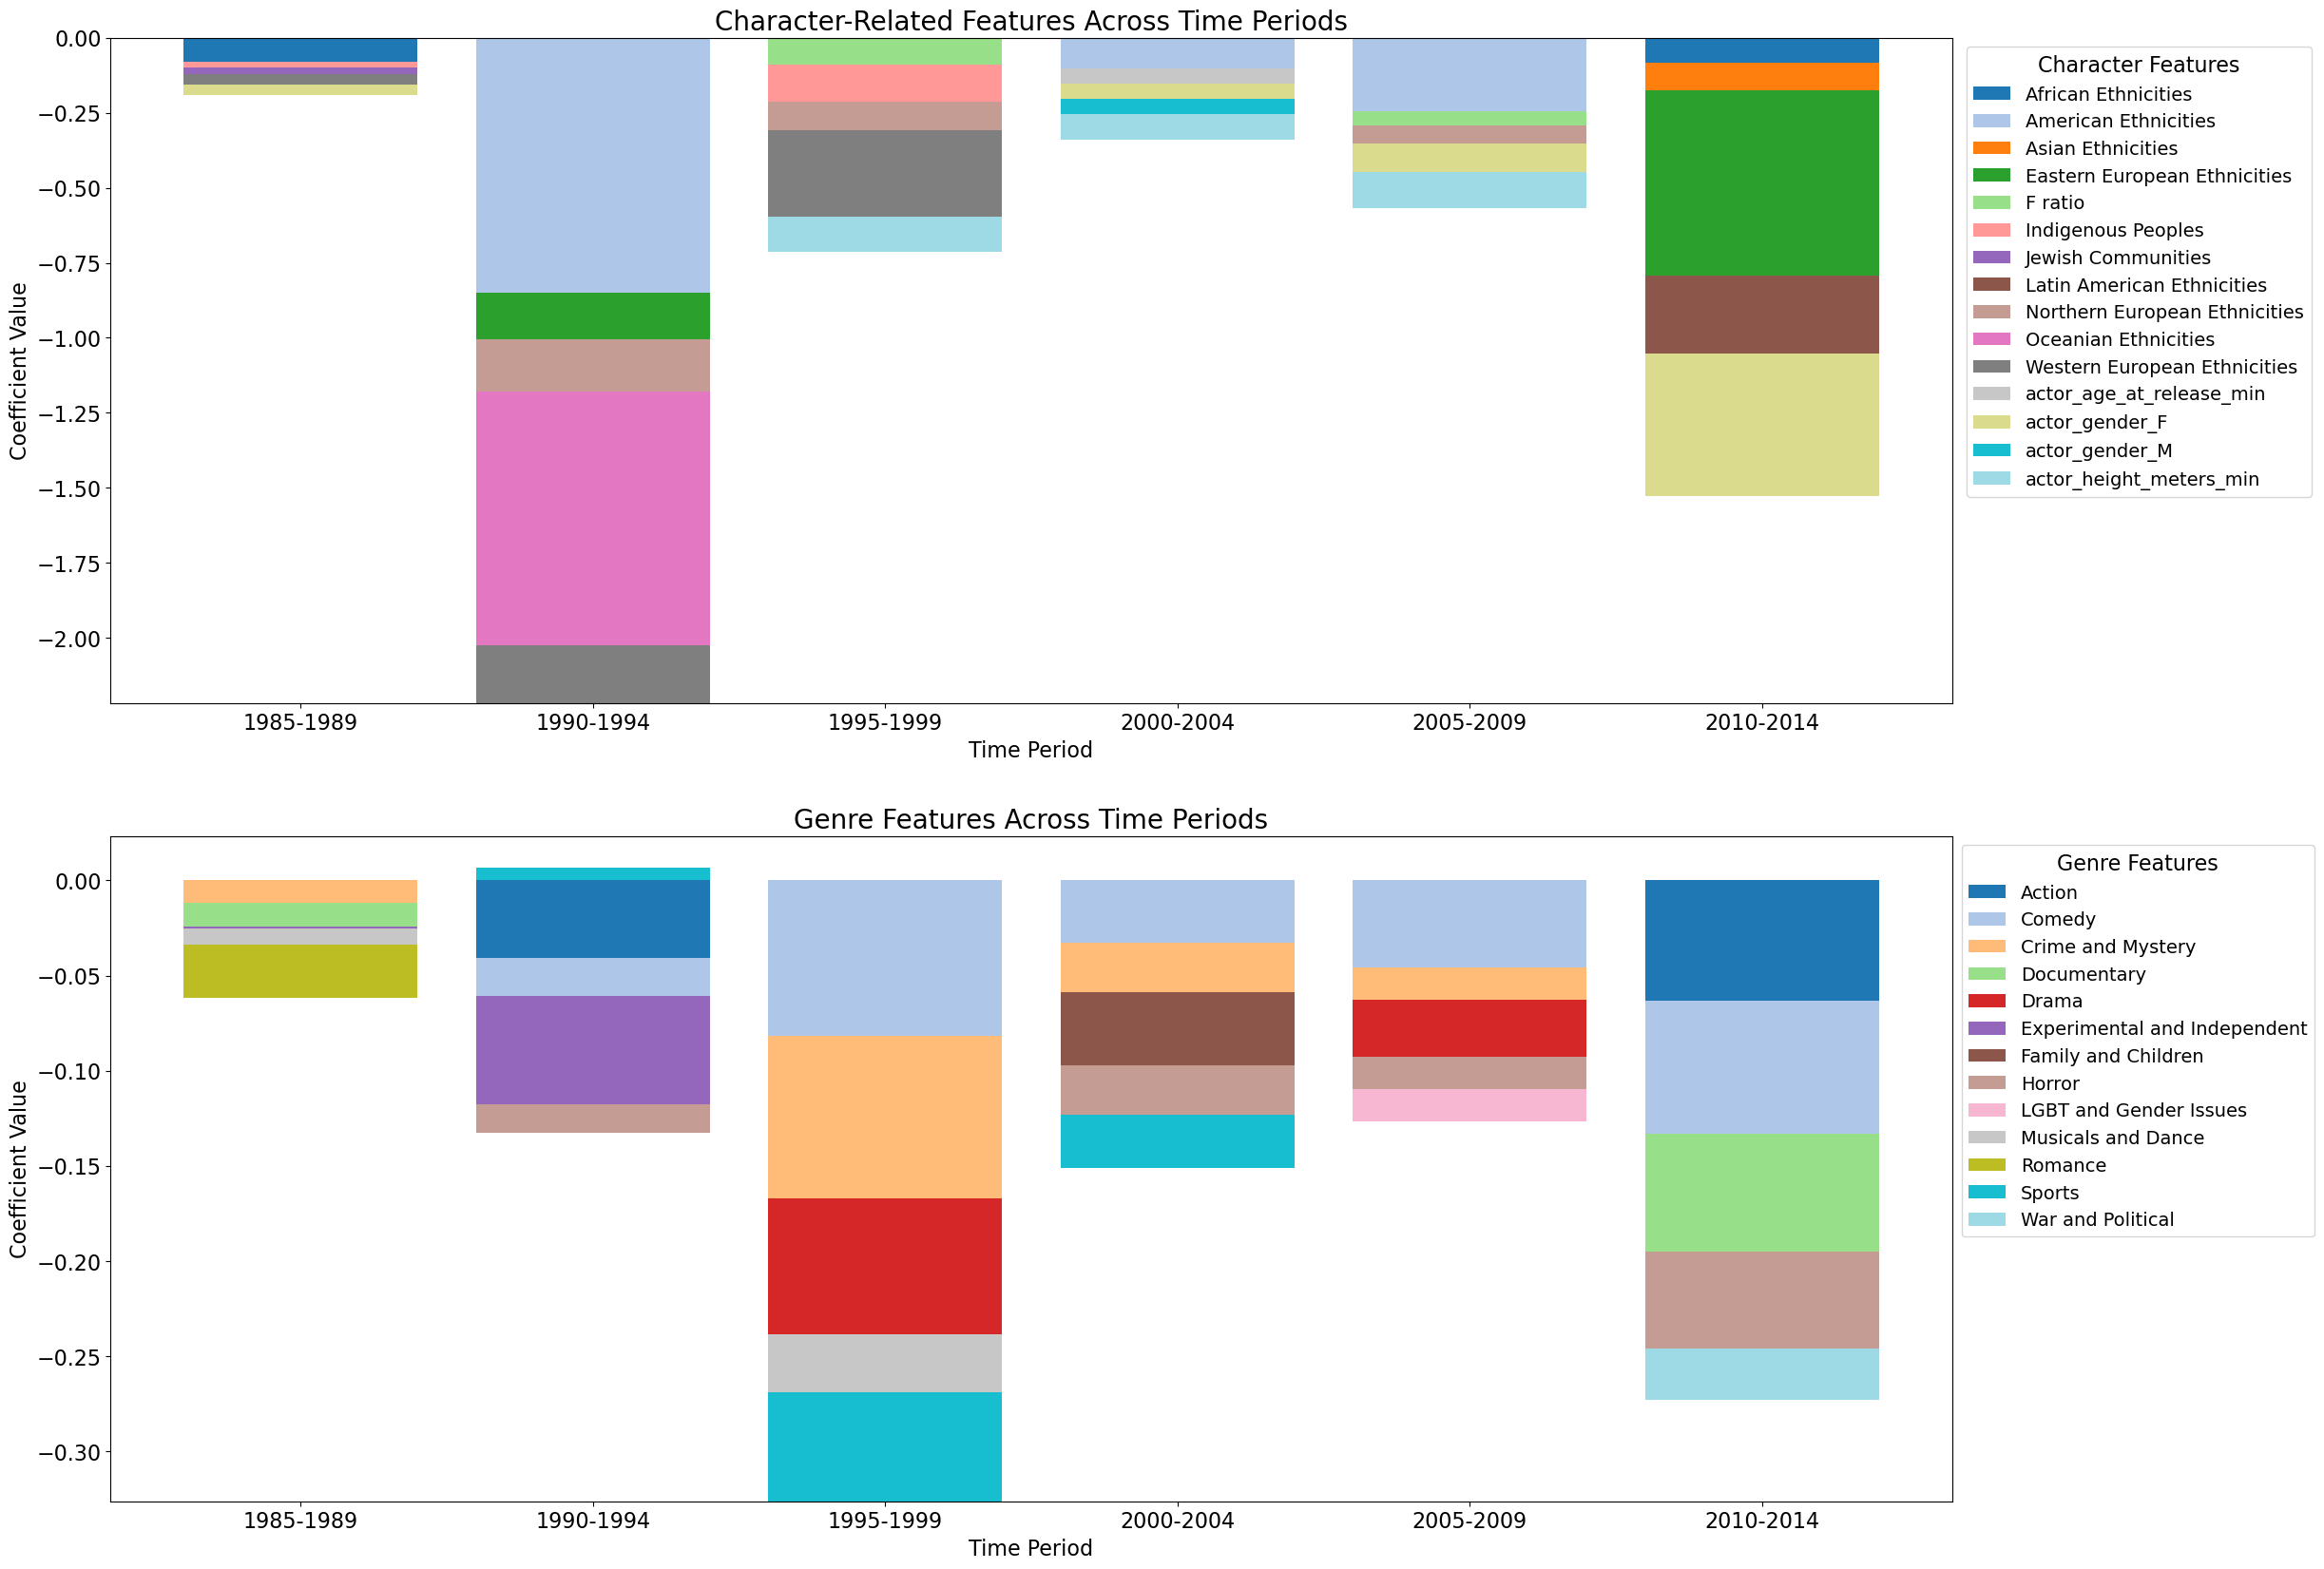

In [184]:
"""Plot the most important features from our logistic regression analysis"""
# Create DataFrames for character and genre features
character_df = pd.DataFrame()
genre_df = pd.DataFrame()

for period, features in features_of_interest.items():
    if len(features) == 0:  # Skip if no significant features for this period
        continue
    # Extract feature names and coefficients
    period_features = pd.DataFrame({
        'Feature': features['Feature'],
        'Coefficient': features['Coefficient']
    })
    
    # Split into character and genre features
    character_features = period_features[
        period_features['Feature'].str.contains('actor|ethnicities|F ratio|people|communities', case=False, regex=True)
    ].copy()
    
    # Genre features are everything that's not a character feature
    genre_features = period_features[
        ~period_features['Feature'].str.contains('actor|ethnicities|F ratio|people|communities', case=False, regex=True)
    ].copy()
    
    # Keep only top 5 genre features by coefficient magnitude
    genre_features = genre_features.sort_values('Coefficient', ascending=True).head(5)
    character_features = character_features.sort_values('Coefficient', ascending=True).head(5)

    #if not character_features.empty:
    character_features['Period'] = period
    character_df = pd.concat([character_df, character_features])
        
    #if not genre_features.empty:
    genre_features['Period'] = period
    genre_df = pd.concat([genre_df, genre_features])


# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20))

# Define distinct color palettes for each plot with more vibrant colors
char_colors = plt.cm.tab20(np.linspace(0, 1, len(character_df['Feature'].unique())))
genre_colors = plt.cm.tab20(np.linspace(0, 1, len(genre_df['Feature'].unique())))

# Plot character features if we have any
char_plot_data = character_df.pivot_table(
    index='Period', 
    columns='Feature',
    values='Coefficient',
    fill_value=0
)
char_plot_data.plot(kind='bar', stacked=True, width=0.8, ax=ax1, color=char_colors)
ax1.set_title("Character-Related Features Across Time Periods", fontsize=20)
ax1.set_xlabel("Time Period", fontsize=16)
ax1.set_ylabel("Coefficient Value", fontsize=16)
ax1.tick_params(axis='x', rotation=0, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(title="Character Features", bbox_to_anchor=(1.2, 1), fontsize=14, title_fontsize=16)
# Plot genre features if we have any
genre_plot_data = genre_df.pivot_table(
    index='Period',
    columns='Feature', 
    values='Coefficient',
    fill_value=0
)
genre_plot_data.plot(kind='bar', stacked=True, width=0.8, ax=ax2, color=genre_colors)
ax2.set_title("Genre Features Across Time Periods", fontsize=20)
ax2.set_xlabel("Time Period", fontsize=16)
ax2.set_ylabel("Coefficient Value", fontsize=16)
ax2.tick_params(axis='x', rotation=0, labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
legend = ax2.legend(title="Genre Features", bbox_to_anchor=(1.0, 1), fontsize=14, title_fontsize=16)

plt.show()